In [1]:
#Speckle

import numpy as np
import scipy.ndimage as ndi
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tifffile as tiff
import os
from moviepy.editor import VideoFileClip
import seaborn as sns
import pickle as pickle
from scipy.stats import linregress
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from scipy.optimize import minimize, Bounds
from scipy.ndimage import uniform_filter1d
from scipy.stats import pearsonr

#HbT

# -*- coding: utf-8 -*-
"""
Created on Thu Jan 12 13:38:43 2023

@author: vincent chouinard
"""
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.filters import threshold_local
import imageio
import sys
import imageio.v2 as imageio
from PyQt5.QtWidgets import QFileDialog, QApplication
import tifffile as tiff
from scipy import stats, ndimage
from scipy.ndimage import gaussian_filter1d, minimum_filter1d
from scipy.signal import medfilt

module_path = r'/Users/vincentchouinard/Documents/GitHub/Widefield-Imaging-analysis'
sys.path.insert(1,module_path)
from WFmovie import WFmovie, create_channel, regress_timeseries, save_figures_as_gif


module_path_chouine = r'/Users/vincentchouinard/Documents/GitHub/WideField'
sys.path.insert(2, module_path_chouine)
from MIFFE import *
from atlas_functions import *

2024-04-14 13:21:55.759865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
colors = {'blue':'#59D0FF', 'orange':'#FFA81C', 'purple':'#B482FF', 'red':'#FF5E5E', 'green':'#83E181', 'pink':'#EFAAEC', 'gray':'#BEBEBE', 'black': '#434343'}

In [3]:
def speckle_contrast(raw_speckle_data, window_size=5):
    num_frames, height, width = raw_speckle_data.shape
    contrast_data = np.zeros((num_frames, height, width))
 
    for frame_idx in range(num_frames):
        frame_data = raw_speckle_data[frame_idx].astype(np.float64)
 
        # Calculate local mean and standard deviation for the current frame
        local_mean = ndi.uniform_filter(frame_data, size=window_size)
        local_variance = ndi.uniform_filter(frame_data**2, size=window_size) - local_mean**2
        local_std = np.sqrt(local_variance)
        # Calculate speckle contrast for the current frame
        contrast_data[frame_idx] = local_std / local_mean
 
    return contrast_data

def tif_to_array(tif_path):
    # Read the tif file
    with tiff.TiffFile(tif_path) as tif:
        # Initialize an empty list to store arrays
        array_list = []

        # Iterate over each page in the tif file
        for page in tif.pages:
            # Add the page's array to the list
            array_list.append(page.asarray())

        # Stack the arrays to form a 3D array
        tif_array = np.stack(array_list, axis=0)

    return tif_array

def select_rectangle(image):
    img = (image / np.max(image) * 255).astype(np.uint8)
    cv2.namedWindow('Select ROI')
    cv2.imshow('Select ROI', img)
    rectangle = cv2.selectROI('Select ROI', img)
    cv2.waitKey(10)
    cv2.destroyAllWindows()
    cv2.waitKey(10)
    return rectangle

def select_rectangle_v2(image):
    # Scale the image intensities from the 2nd to 98th percentile to 0-255
    p2, p98 = np.percentile(image, (2, 98))
    img = np.clip((image - p2) / (p98 - p2) * 255, 0, 255).astype(np.uint8)
    
    # Alternative: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # img = clahe.apply(img)
    
    cv2.namedWindow('Select ROI', cv2.WINDOW_NORMAL)
    cv2.imshow('Select ROI', img)
    rectangle = cv2.selectROI('Select ROI', img, False, False)
    cv2.waitKey(1)  # Using a short wait time
    cv2.destroyAllWindows()
    for i in range(1, 5):
        cv2.waitKey(1)  # Ensuring window closure on some systems
    
    return rectangle

import cv2
import numpy as np

def select_rectangle_v3(image, squared=False):
    # Scale the image intensities from the 2nd to 98th percentile to 0-255
    p2, p98 = np.percentile(image, (2, 98))
    img = np.clip((image - p2) / (p98 - p2) * 255, 0, 255).astype(np.uint8)

    # Initialize variables
    global x_start, y_start, x_end, y_end, drawing
    drawing = False
    x_start, y_start, x_end, y_end = -1, -1, -1, -1

    # Mouse callback function
    def draw_rectangle(event, x, y, flags, param):
        global x_start, y_start, x_end, y_end, drawing

        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            x_start, y_start, x_end, y_end = x, y, x, y

        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing:
                x_end, y_end = x, y

        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            x_end, y_end = x, y

    cv2.namedWindow('Select ROI', cv2.WINDOW_NORMAL)
    cv2.setMouseCallback('Select ROI', draw_rectangle)

    while True:
        img_copy = img.copy()
        if drawing or (x_end != -1 and y_end != -1):
            # Enforce square aspect ratio if squared is True
            if squared:
                side_length = max(abs(x_end - x_start), abs(y_end - y_start))
                x_end = x_start + side_length * np.sign(x_end - x_start)
                y_end = y_start + side_length * np.sign(y_end - y_start)
            
            cv2.rectangle(img_copy, (x_start, y_start), (x_end, y_end), (255, 0, 0), 2)
        
        cv2.imshow('Select ROI', img_copy)
        k = cv2.waitKey(1) & 0xFF
        if k == ord('q') or k == 27:  # Quit if 'q' or ESC is pressed
            break

    cv2.destroyAllWindows()
    cv2.waitKey(1)  # Adding a short delay

    # Ensure top-left and bottom-right ordering
    x1, y1 = min(x_start, x_end), min(y_start, y_end)
    x2, y2 = max(x_start, x_end), max(y_start, y_end)
    
    
    return (x1, y1, x2 - x1, y2 - y1)

def cv2_rect_to_corners(rect):

    x, y, width, height = rect
    return (y, y + height, x, x + width)


def crop_image(image, rectangle):
    return image[int(rectangle[1]):int(rectangle[1] + rectangle[3]),
           int(rectangle[0]):int(rectangle[0] + rectangle[2])]

def crop(arr, rectangle = None, squared=False):
    if rectangle == None:
        rectangle = select_rectangle_v3(arr[0], squared)
    
    # Apply cropping to the entire array
    cropped_arr = arr[:, int(rectangle[1]):int(rectangle[1] + rectangle[3]),
           int(rectangle[0]):int(rectangle[0] + rectangle[2])]

    return cropped_arr

def compute_K(tau_c, T=0.01, beta=1):
    term1 = tau_c / T
    term2 = tau_c**2 / (2 * T**2)
    exponent = np.exp(-2 * T / tau_c) - 1
    K = (1 / beta) * np.sqrt(term1 + term2 * (exponent))
    return K

def find_taus(Ks, T=0.01, beta=1):
    # Sort x_values and K_values based on x_values for plotting (in comment because datasets are all ordered now)
    #x_values, K_values = zip(*sorted(zip(speeds, Ks)))

    # Define the function to find tau_c for a given K, T, and beta
    def find_tau_c(K, T, beta):
        # Define the equation we want to solve: compute_K(tau_c, T, beta) - K = 0
        def equation(tau_c):
            return compute_K(tau_c, T, beta) - K
        # Initial guess for tau_c will be a small value since T is also small
        tau_c_initial_guess = 0
        # Solve for tau_c that satisfies the equation
        tau_c_solution = fsolve(equation, tau_c_initial_guess)
        return tau_c_solution[0]

    # Now we loop over the K values and calculate tau_c for each
    taus = [find_tau_c(K, T, beta) for K in Ks]
    return 1/np.array(taus)

def normalize_array_1d(array):
    array=array[10:-10]
    return 2 * (array - array.min()) / (array.max() - array.min()) - 1

def mean_filter_1d(array, kernel_size=21):
    return uniform_filter1d(array, size=kernel_size)

def baseline_minfilter(signal, window=300, sigma1=5, sigma2=100, debug=False):
    signal_flatstart = np.copy(signal)
    signal_flatstart[0] = signal[1]
    smooth = gaussian_filter1d(signal_flatstart, sigma1)
    mins = minimum_filter1d(smooth, window)
    baseline = gaussian_filter1d(mins, sigma2)
    if debug:
        debug_out = np.asarray([smooth, mins, baseline])
        return debug_out
    else:
        return baseline
    

def optimize_coefficients(taus, hbt_series):
    # Define the objective function to minimize (negative correlation)
    def objective_function(coeffs, taus, hbt_series):
        scale, offset = coeffs
        modified_taus = scale * taus - offset
        correlation, _ = pearsonr(modified_taus, hbt_series)
        return -correlation  # Minimize this to maximize correlation

    # Initial guess for the coefficients
    initial_guess = [0.01, 54]
    bounds = Bounds([0.008, 54], [0.012, 58])
    
    # Run the optimization
    result = minimize(objective_function, initial_guess, args=(taus, hbt_series), bounds=bounds)
    
    # Return the optimal coefficients
    return result.x


def grid_search_optimize(sig1, sig2, scale_range, steps=1000):
    # Define the grid
    scale_values = np.linspace(scale_range[0], scale_range[1], steps)
    
    # Initialize the best values
    best_scale = None

    best_correlation = -1  # Start with the worst possible correlation
    
    corr=[]
    # Iterate over all combinations of scale and offset
    for scale in tqdm(scale_values):
        # Apply transformation and mean filter
        scaled_sig1 = (scale * sig1)
        # Compute correlation with hbt_series
        correlation, _ = pearsonr(scaled_sig1, sig2)
        corr.append(correlation)
        # Update the best parameters if this combination is better
        if correlation > best_correlation:
            best_correlation = correlation
            best_scale = scale
                
    return best_scale, best_correlation, corr


def grid_search_minimize_lse(sig1, sig2, scale_range, steps=1000):
    # Define the grid
    scale_values = np.linspace(scale_range[0], scale_range[1], steps)
    
    # Initialize the best values
    best_scale = None
    lowest_lse = np.inf  # Start with the highest possible error
    
    lse_values = []  # Store LSE values for each scale
    
    # Iterate over all combinations of scale
    for scale in tqdm(scale_values):
        # Apply transformation
        scaled_sig1 = scale * sig1
        # Compute least squared error with sig2
        lse = np.sum((scaled_sig1 - sig2)**2)
        lse_values.append(lse)
        # Update the best parameters if this combination results in lower LSE
        if lse < lowest_lse:
            lowest_lse = lse
            best_scale = scale
                
    return best_scale, lowest_lse, lse_values


def denormalize_lsci(lsci_path):
    static_path = os.path.abspath(os.path.join(lsci_path, os.pardir)) + '/static_LSCI.tif'
    bg = tiff.imread(static_path)
    mean = np.mean(bg)
    ims = tiff.imread(lsci_path)
    return ims * mean
    

def generate_paths(example_path, sessions, mice, formating=False, verbose=True, check_remove=True):
    
    if formating:
        path_segments = example_path.split('/')[1:]

        for session in sessions:        
            path_segments = [segment.replace(session, '{session}') for segment in path_segments]

        for mouse in mice:
            path_segments = [segment.replace(mouse,'{mouse}') for segment in path_segments]

        example_path_format = '/'.join(path_segments)
        
    else:
        example_path_format = example_path
    
    paths = []
    # Generate paths for each combination of session and mouse
    for session in sessions:
        for mouse in mice:
            # Use string formatting to replace placeholders with actual identifiers
            new_path = example_path_format.format(session=session, mouse=mouse)
            paths.append(new_path)
    
    if check_remove:
        # Remove non-existing paths
        paths = [path for path in paths if os.path.exists(path)]
    
    if verbose:
        print(paths)
            
    return paths

# Saving and Loading datasets

In [179]:
save_path = '/Users/vincentchouinard/Documents/Maitrise/Data/CVR_M34_M35_M37_S1toS8.pkl'

# Open the file for writing in binary mode and save the array using pickle
with open(save_path, 'wb') as file:
    pickle.dump(M343537, file)

print(f'Array has been saved to {save_path}')

Array has been saved to /Users/vincentchouinard/Documents/Maitrise/Data/CVR_M34_M35_M37_S1toS8.pkl


In [4]:
load_path = '/Users/vincentchouinard/Documents/Maitrise/Data/CVR_M34_M35_S1toS8.pkl'

with open(load_path, 'rb') as file:
    M3435 = pickle.load(file)

# Choosing data

In [87]:
example_path = '/Volumes/DDE_Chouine/_CVR_Dataset/{session}/Dataset/CVR_{mouse}_{session}'
sessions = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8']
mice = ['M37', 'M38']

paths = generate_paths(example_path , sessions , mice , formating=False , verbose = True , check_remove = True)

['/Volumes/DDE_Chouine/_CVR_Dataset/S1/Dataset/CVR_M37_S1', '/Volumes/DDE_Chouine/_CVR_Dataset/S2/Dataset/CVR_M37_S2', '/Volumes/DDE_Chouine/_CVR_Dataset/S3/Dataset/CVR_M37_S3', '/Volumes/DDE_Chouine/_CVR_Dataset/S4/Dataset/CVR_M37_S4', '/Volumes/DDE_Chouine/_CVR_Dataset/S5/Dataset/CVR_M37_S5', '/Volumes/DDE_Chouine/_CVR_Dataset/S5/Dataset/CVR_M38_S5', '/Volumes/DDE_Chouine/_CVR_Dataset/S6/Dataset/CVR_M37_S6', '/Volumes/DDE_Chouine/_CVR_Dataset/S6/Dataset/CVR_M38_S6', '/Volumes/DDE_Chouine/_CVR_Dataset/S7/Dataset/CVR_M37_S7', '/Volumes/DDE_Chouine/_CVR_Dataset/S7/Dataset/CVR_M38_S7', '/Volumes/DDE_Chouine/_CVR_Dataset/S8/Dataset/CVR_M37_S8', '/Volumes/DDE_Chouine/_CVR_Dataset/S8/Dataset/CVR_M38_S8']


In [89]:
# Creates rectangles instead of windows.

rectangles = []
for path in paths:
    hb_path = path + '/Hb_data/dHbT.tif'
    
    # Open the TIFF file and read the first frame
    with tiff.TiffFile(hb_path) as tif:
        first_frame = tif.pages[200].asarray()
        
    rectangle = select_rectangle_v2(first_frame)
    rectangles.append(cv2_rect_to_corners(rectangle))


# Opening data into a data list

In [91]:
#r_squared_values = []
data = []
ir = False

for path, window in tqdm(zip(paths , rectangles)):
    
    if ir:
        ir_path = path + '/Correction/ir_movie.tif'
        im = tiff.imread(ir_path)
        K = speckle_contrast(im)
        ir_series = np.mean(K[:,2*window[0]:2*window[1], 2*window[2]:2*window[3]],axis=(1,2))
        nonfilt_taus = find_taus(ir_series)
        taus = mean_filter_1d(nonfilt_taus)
        taus_baseline = baseline_minfilter(taus)
        bs_taus = (taus - taus_baseline) + np.mean(taus_baseline) #still scaled around original value for rel measures
        
    
    hb_path = path + '/Hb_data/dHbT.tif'
    im2 = tiff.imread(hb_path)
    nonfilt_hbt_series = np.mean(im2[:,window[0]:window[1],window[2]:window[3]],axis=(1,2))
    hbt_series = mean_filter_1d(nonfilt_hbt_series)
    hbt_baseline = baseline_minfilter(hbt_series)
    bs_hbt = hbt_series - hbt_baseline
    
    if ir:
        data.append([bs_hbt, bs_taus])
    else:
        data.append([bs_hbt])
    
if ir:
    dataset2 = np.zeros((len(paths),2,bs_hbt.shape[0]))
    for i, arr in enumerate(data):
        dataset3[i] = np.array(arr)
        
else:
    dataset3 = np.zeros((len(paths), bs_hbt.shape[0]))
    for i, arr in enumerate(data):
        dataset3[i] = np.array(arr)

12it [03:28, 17.35s/it]


NameError: name 'dataset3' is not defined

# Tests on R^2

In [5]:
for i in range(len(data)):
    bs_hbt, bs_taus = data[i]
    # Assuming bs_hbt and bs_taus are defined
    plt.figure(figsize=(8, 8))  # Makes the plot square by setting equal width and height
    plt.scatter(bs_hbt, bs_taus, color='black', s=10, alpha=0.5)  # s is the size of the points
    #plt.grid(True)  # Enables the grid

     # Linear regression
    slope, intercept = np.polyfit(bs_hbt[:1100], bs_taus[:1100], 1)
    x = np.array([min(bs_hbt), max(bs_hbt)])
    y = slope * x + intercept
    linear_pred = slope * bs_hbt[:1100] + intercept
    linear_ss_res = np.sum((bs_taus[:1100] - linear_pred) ** 2)
    linear_ss_tot = np.sum((bs_taus[:1100] - np.mean(bs_taus[:1100])) ** 2)
    linear_r_squared = 1 - (linear_ss_res / linear_ss_tot)

    # Second-order polynomial fit
    coefficients = np.polyfit(bs_hbt, bs_taus, 2)
    polynomial = np.poly1d(coefficients)
    quadratic_pred = polynomial(bs_hbt)
    quadratic_ss_res = np.sum((bs_taus - quadratic_pred) ** 2)
    quadratic_ss_tot = np.sum((bs_taus - np.mean(bs_taus)) ** 2)
    quadratic_r_squared = 1 - (quadratic_ss_res / quadratic_ss_tot)

    # Save R^2 in a list
    r_squared_values.append([linear_r_squared, quadratic_r_squared])

     # Second-order polynomial fit
    coefficients = np.polyfit(bs_hbt, bs_taus, 2)
    polynomial = np.poly1d(coefficients)
    x2 = np.linspace(min(bs_hbt), max(bs_hbt), 500)  # Generates x values for plotting the polynomial
    y2 = polynomial(x)

    plt.plot(x, y, color='red', linewidth=2)  # Plotting the regression line in red

    plt.xlabel('bs_hbt')  # Label for the x-axis
    plt.ylabel('bs_taus')  # Label for the y-axis
    plt.title('Scatter Plot of bs_hbt vs. bs_taus with Linear Regression')  # Title of the plot
    plt.show()

NameError: name 'data' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Array creation
# calculate Rsquared here

# Calculate means and standard deviations for each dataset
means = arr.mean(axis=1)
stds = arr.std(axis=1)

# The x locations for the groups
ind = [0,0.08]

# Bar width
width = 0.05

# Create the plot
fig, ax = plt.subplots(figsize=(6,6))
bars = ax.bar(ind, means, width, yerr=stds, color=[colors['bleu'], colors['vert']], capsize=5, edgecolor=colors['noir'])

# Plot individual data points
for i, row in enumerate(arr):
    x_positions = np.full_like(row, ind[i], dtype=float)  # Positions for all data points in this row
    ax.plot(x_positions, row, 'o', mfc='none', mec=black)  # Plot data points as non-filled circles

# Add some text for labels, title, and axes ticks
ax.set_ylabel('Values')
#ax.set_title('Values by dataset')
ax.set_xticks(ind)
ax.set_xticklabels(['Linéaire', 'Quadratique'])
#ax.legend(bars, ['Dataset 1', 'Dataset 2'])

# Show the plot
plt.show()

In [64]:
for i in range(len(r_squared_values)):
    arr[:,i] = r_squared_values[i][0], r_squared_values[i][1]

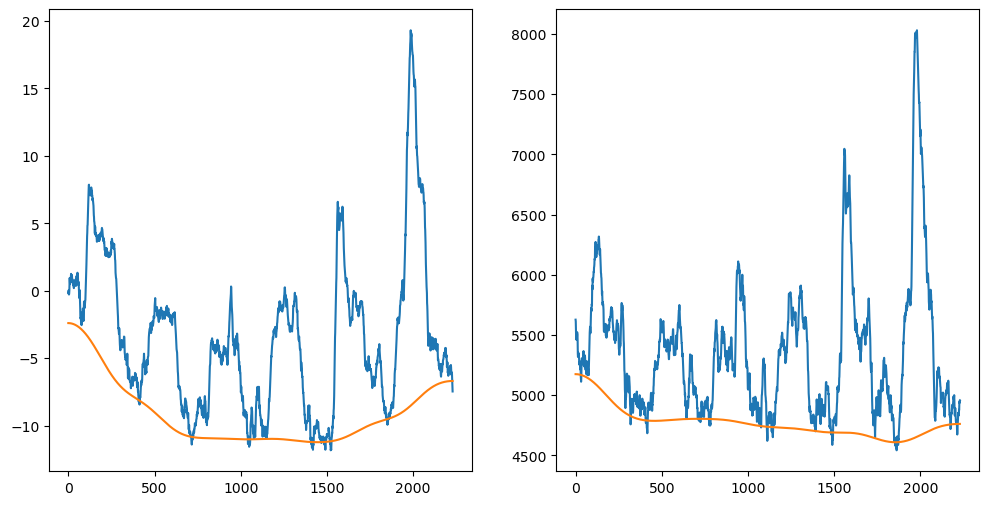

In [15]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(hbt_series)
ax[0].plot(hbt_baseline)
ax[1].plot(taus)
ax[1].plot(taus_baseline)

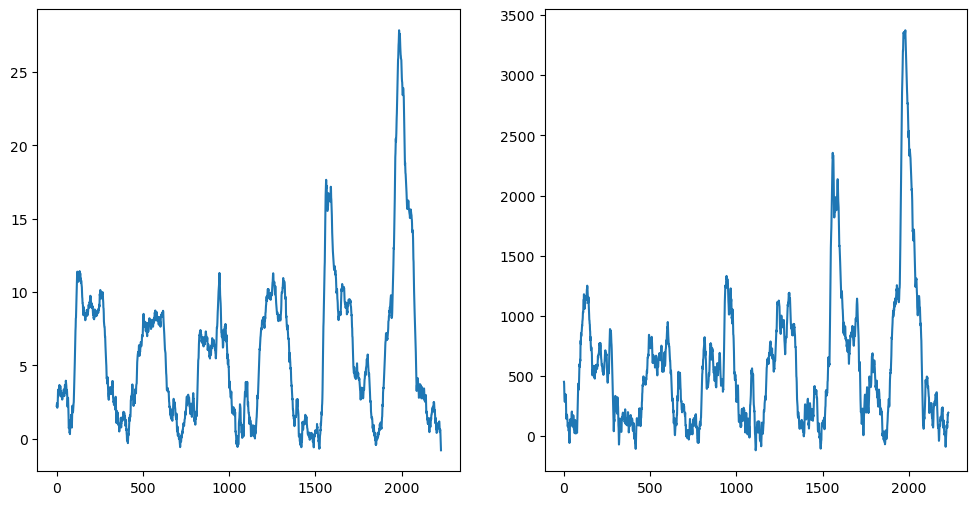

In [16]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(hbt_series-hbt_baseline)
ax[1].plot(taus-taus_baseline)

#### si dhbt augmente, r augmente

#### si K augmente, flow diminue, si flow diminue, r diminue. c'est la règle de poissieux (voir Jé me rappelle pu du nom). Mais c'est dû au fait que le cerveau tente d'équilibrer la pression partout, donc pour que la pression reste constante y faut que si le rayon du vaisseau augmente, le flow augmente aussi.

#### Stims are 80 frames baseline , 180 frames onset , 80 frames offset. So it's 340 frames. (80 and not 90 because of abberant values

# CVR dHbT mean response

In [334]:
hb_avg5 = np.zeros((18,360))
hb_avg10 = np.zeros((18,360))

In [40]:
blocks = [(90,270), (450,630), (810, 990), (1170,1350), (1530,1710), (1890,2070)]

In [336]:
for i in range(new_arr.shape[0]):
    hb_avg5[3*i] = new_arr[i,0,blocks[0][0]-90:blocks[0][1]+90]
    hb_avg5[3*i + 1] = new_arr[i,0,blocks[1][0]-90:blocks[1][1]+90]
    hb_avg5[3*i + 2] = new_arr[i,0,blocks[2][0]-90:blocks[2][1]+90]
    
for i in range(new_arr.shape[0]):
    hb_avg10[3*i] = new_arr[i,0,blocks[3][0]-90:blocks[3][1]+90]
    hb_avg10[3*i + 1] = new_arr[i,0,blocks[4][0]-90:blocks[4][1]+90]
    hb_avg10[3*i + 2] = new_arr[i,0,blocks[5][0]-90:blocks[5][1]+90]

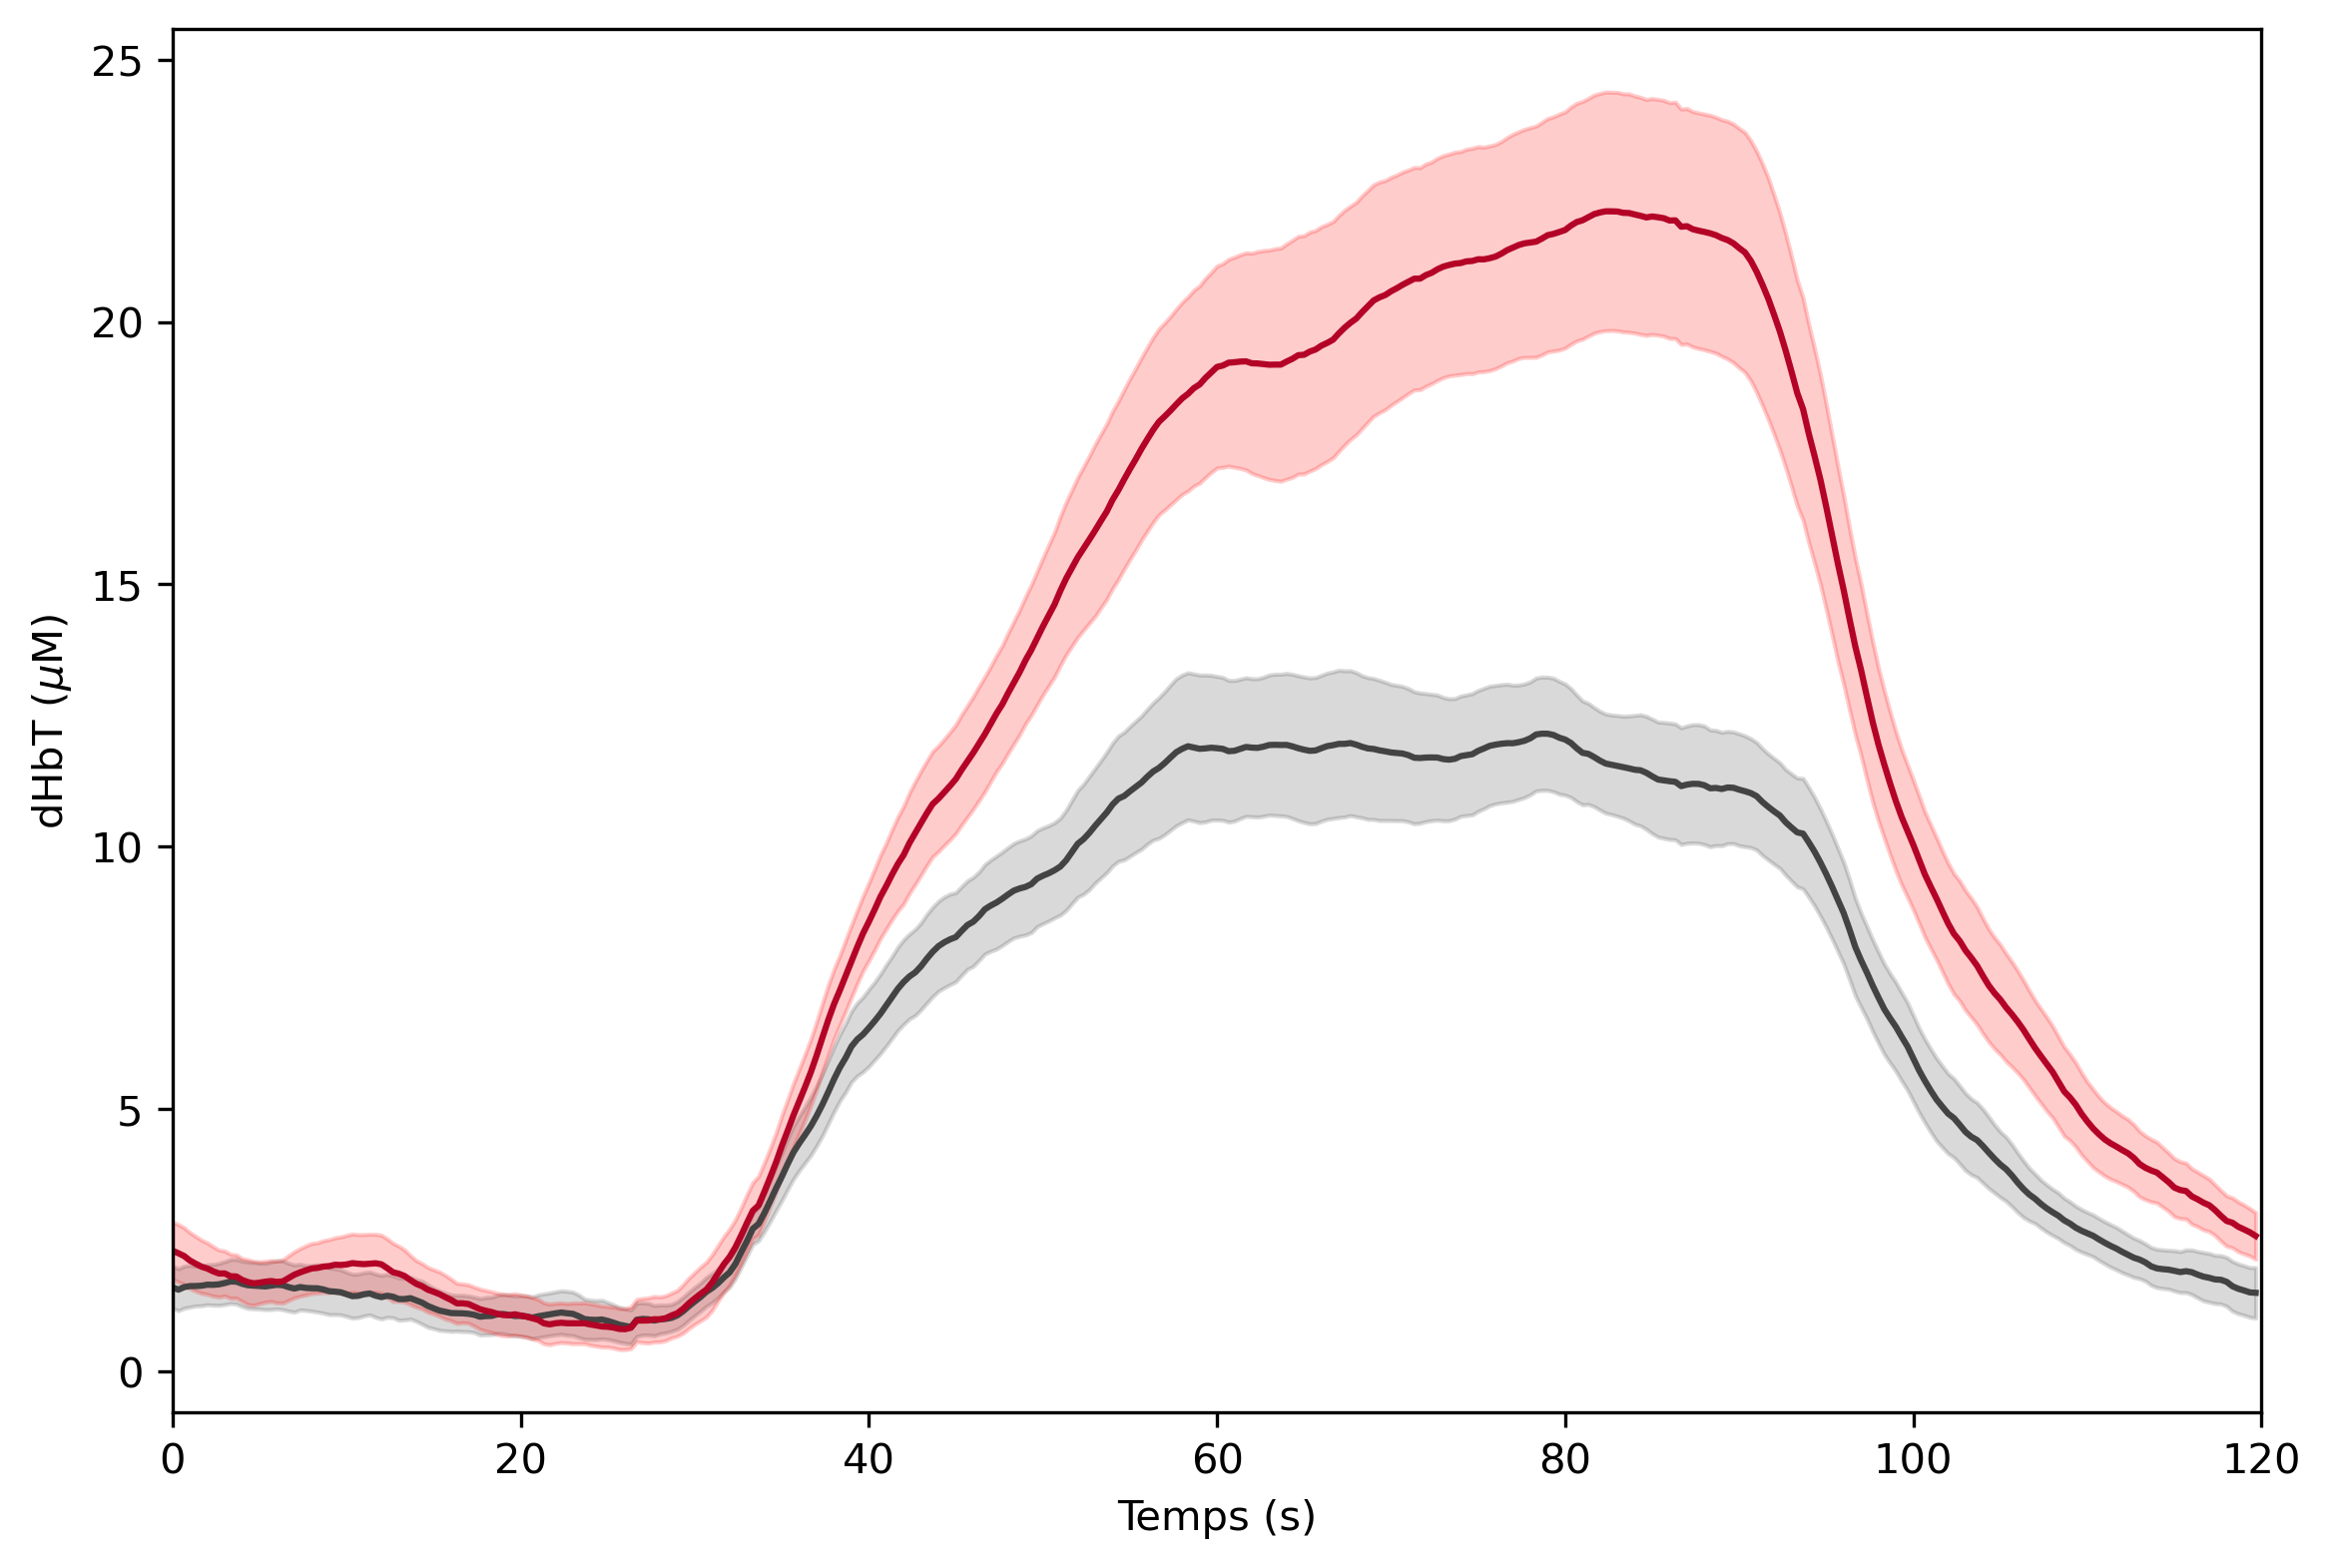

In [8]:
fig, ax = plt.subplots(figsize = (9,6),dpi=300)

avg5 = np.mean(hb_avg5,axis=0)

# Calculate the SEM along axis=0
sem5 = np.std(hb_avg5, axis=0, ddof=1) / np.sqrt(len(hb_avg5))

x_values5 = np.arange(360)

# Plot the mean values as a line plot
plt.plot(x_values5, avg5, label='5%', color=colors['black'])

# Add a shaded area to represent the standard deviation
plt.fill_between(x_values5, avg5 - sem5, avg5 + sem5, alpha=0.2, color=colors['black'])

avg10 = np.mean(hb_avg10,axis=0)

# Calculate the SEM along axis=0
sem10 = np.std(hb_avg10, axis=0, ddof=1) / np.sqrt(len(hb_avg10))

x_values10 = np.arange(360)

# Plot the mean values as a line plot
plt.plot(x_values10, avg10, label='10%', color='#b30326')

# Add a shaded area to represent the standard deviation
plt.fill_between(x_values10, avg10 - sem10, avg10 + sem10, alpha=0.2, color='#ff0303')

# Add labels and legend
plt.xlabel('Temps (s)')
plt.ylabel('dHbT ($\mu$M)')
plt.xlim([0,360])
plt.xticks([0,60,120,180,240,300,360], [0,20,40,60,80,100,120])
#plt.title('Mean Responses of 5% and 10% CO2 challenges')
#plt.legend(loc='upper left')

# Show the plot
#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/notebook_saves/hbt_mean_response.svg')
plt.show()

T-statistic: -3.849378444236991, P-value: 0.0004975470870958859


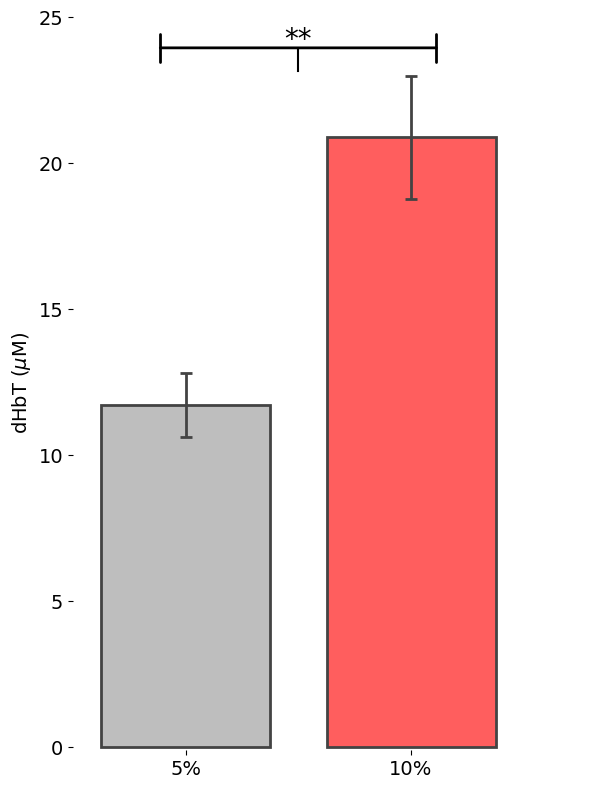

In [152]:
from scipy.stats import ttest_ind, sem # Import sem for standard error of the mean
import matplotlib.pyplot as plt
import numpy as np

hb5 = []
hb10 = []
for i in range(18):
    hb5.append(np.mean(hb_avg5[i,180:270]))
    hb10.append(np.mean(hb_avg10[i,180:270]))

# Perform two-sample t-test
t_stat, p_value = ttest_ind(hb5, hb10)

# Print t-statistic and p-value
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Create a barplot
labels = ['5%', '10%']
means = [np.mean(hb5), np.mean(hb10)]
errors = [sem(hb5), sem(hb10)] # Use sem instead of std

# Figure adjustments for aesthetics
plt.figure(figsize=(6, 8)) # Make the figure square and smaller
width = 0.3  # Make bars narrower

# Adjust bar positions to be closer to each other
positions = [0,0.4]


alpha2 = 0.001 # Common significance level
alpha = 0.05 # Common significance level
# Determine the height at which to place the star and bracket
highest_point = max(max(means) + max(errors), star_position) + 0.05  # Adjust as needed

# Place the star between the bars
midpoint = np.mean([positions[0] + width/2, positions[1] - width/2])
if p_value < alpha2:
    plt.text(midpoint, highest_point + 0.8, '**', fontsize=20, ha='center')
elif p_value < alpha:
    plt.text(midpoint, highest_point, '*', fontsize=20, ha='center')

# Draw the bracket
bracket_height = highest_point + 0.8  # Adjust as needed for visual appearance
plt.annotate('', xy=(positions[0] + 3*width/2, bracket_height), xytext=(positions[1] - 3*width/2, bracket_height),
             arrowprops=dict(arrowstyle='|-|', lw=2, color='black'))
# Add a line connecting the top of the bars/error bars to the bracket
plt.plot([midpoint, midpoint], [highest_point, bracket_height - 0.05], color='black', lw=1.5)

# Customization for bar and error bar appearance
bar_properties = {
    'linewidth': 2,        # Width of the bar border
    'color': [colors['gray'], colors['red']],  # Bar fill color
    'capsize': 4, # Cap size for error bars
    'yerr': errors,        # Error values
    'error_kw': {'elinewidth': 2, 'ecolor': colors['black'], 'capthick': 2},
    'zorder': 3,
    'edgecolor': colors['black'] # Ensure bars are plotted over the grid
}  # Error bar properties


#plt.grid(axis='y', linestyle='-', linewidth=2, color='black', alpha=0.5)
plt.bar(positions, means, width, **bar_properties)  # Color of the bar border  # Width of the border around bars)


#plt.bar(positions, means, width, yerr=errors, capsize=5, color=[colors['blue'], colors['red']])
plt.xticks(positions, labels, fontsize=14)
plt.yticks(fontsize=14)# Set custom x-ticks to correspond to the labels
plt.ylabel('dHbT ($\mu$M)', fontsize=14)
plt.tight_layout() # Optional: may help with fitting everything neatly into the figure
plt.gca().spines['top'].set_visible(False)  # Remove the top spine
plt.gca().spines['right'].set_visible(False)  # Remove the right spine
plt.gca().spines['bottom'].set_visible(False)  # Optionally, remove the bottom spine
plt.gca().spines['left'].set_visible(False)  # Optionally, remove the left spine
plt.ylim([-0.1,25.1])
plt.xlim([-0.2,0.7])

#plt.tick_params(left=False, bottom=False)  # Hide ticks
#plt.show()
plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/hbt_barplot.svg')

# dHbT / Speckle (5/10 %) maps

In [9]:
#hb = tiff.imread('/Volumes/DDE_Chouine/_CVR_Dataset/S6/Dataset/CVR_M34_S6/Hb_data/dHbT.tif')
speckle = tiff.imread('/Volumes/DDE_Chouine/_CVR_Dataset/S6/Dataset/CVR_M34_S6/Correction/ir_movie.tif')
K = speckle_contrast(speckle)

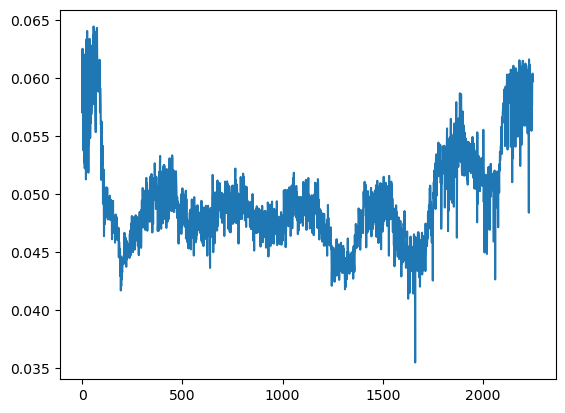

In [186]:
plt.plot(np.mean(K[:,30:530,80:580],axis=(1,2)))

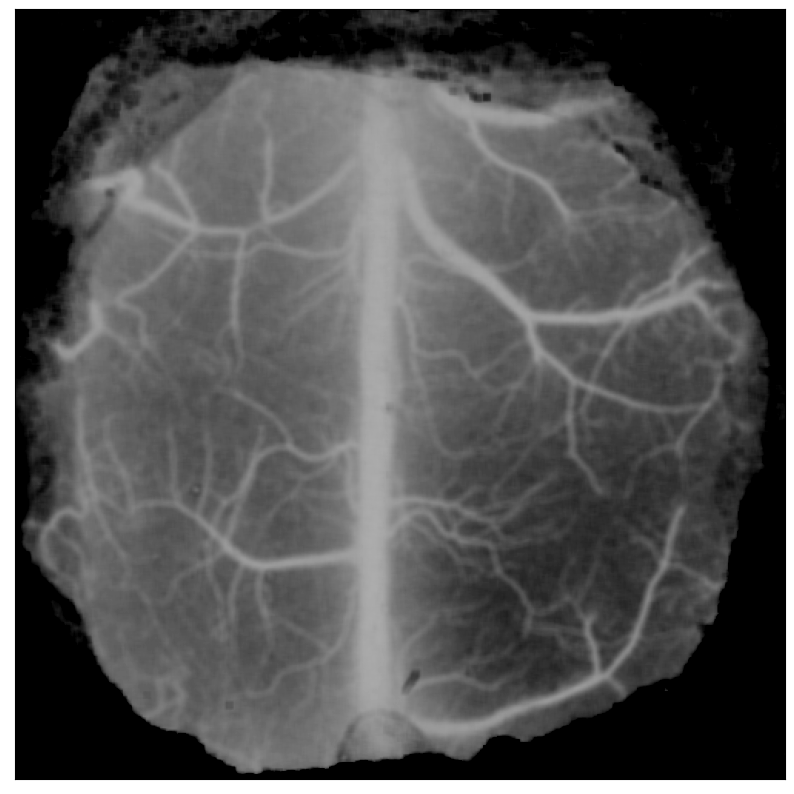

In [28]:
plt.imshow(np.mean(K[90:270,30:530,80:580],axis=0), cmap='gist_yarg',vmin=0,vmax=0.08)
plt.xticks([])
plt.yticks([])
#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/Speckle5.svg')

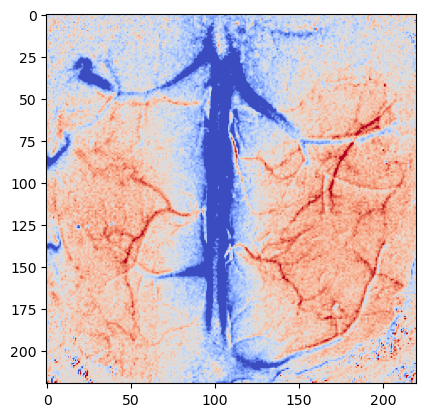

In [341]:
plt.imshow(hb[504,40:260,55:275], cmap='coolwarm',vmin=-20, vmax=20)
#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/CV5map.svg')

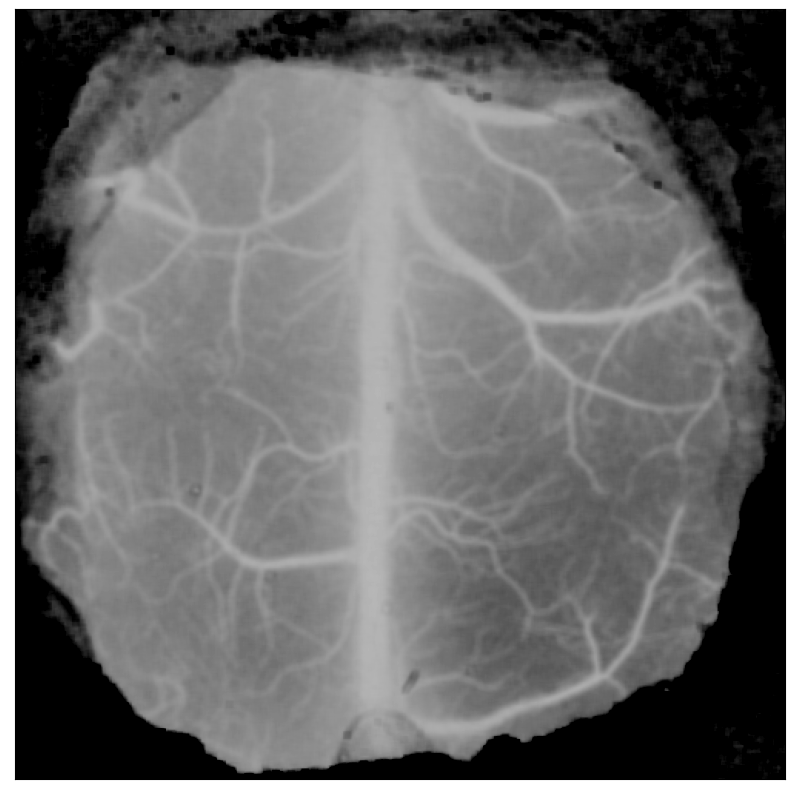

In [26]:
plt.imshow(np.mean(K[1530:1710,30:530,80:580],axis=0), cmap='gist_yarg',vmin=0,vmax=0.08)

plt.xticks([])
plt.yticks([])
#plt.colorbar()
#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/Speckle10_contour.svg')

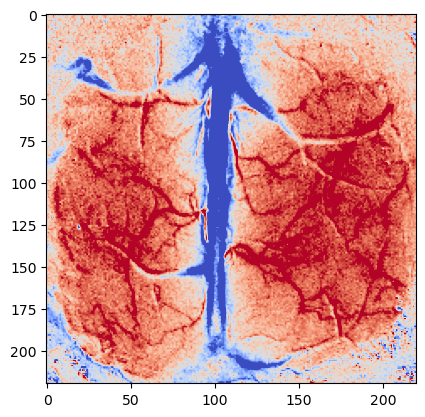

In [342]:
plt.imshow(hb[1600,40:260,55:275], cmap='coolwarm',vmin=-20, vmax=20)
#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/CV10map.svg')

# Avec speckle: 

In [337]:
blocks = [(90,270), (450,630), (810, 990), (1170,1350), (1530,1710), (1890,2070)]

In [338]:
relative_tau = np.zeros((new_arr.shape[0], new_arr.shape[2]))
for i in range(new_arr.shape[0]):
    baseline = baseline_minfilter(new_arr[i,1,:])
    mean_min = np.mean(baseline)
    relative_tau[i,:] = new_arr[i,1,:] / mean_min

In [339]:
tau_avg5 = np.zeros((18,360))
tau_avg10 = np.zeros((18,360))

for i in range(new_arr.shape[0]):
    tau_avg5[3*i] = relative_tau[i,blocks[0][0]-90:blocks[0][1]+90]
    tau_avg5[3*i + 1] = relative_tau[i,blocks[1][0]-90:blocks[1][1]+90]
    tau_avg5[3*i + 2] = relative_tau[i,blocks[2][0]-90:blocks[2][1]+90]
    
for i in range(new_arr.shape[0]):
    tau_avg10[3*i] = relative_tau[i,blocks[3][0]-90:blocks[3][1]+90]
    tau_avg10[3*i + 1] = relative_tau[i,blocks[4][0]-90:blocks[4][1]+90]
    tau_avg10[3*i + 2] = relative_tau[i,blocks[5][0]-90:blocks[5][1]+90]

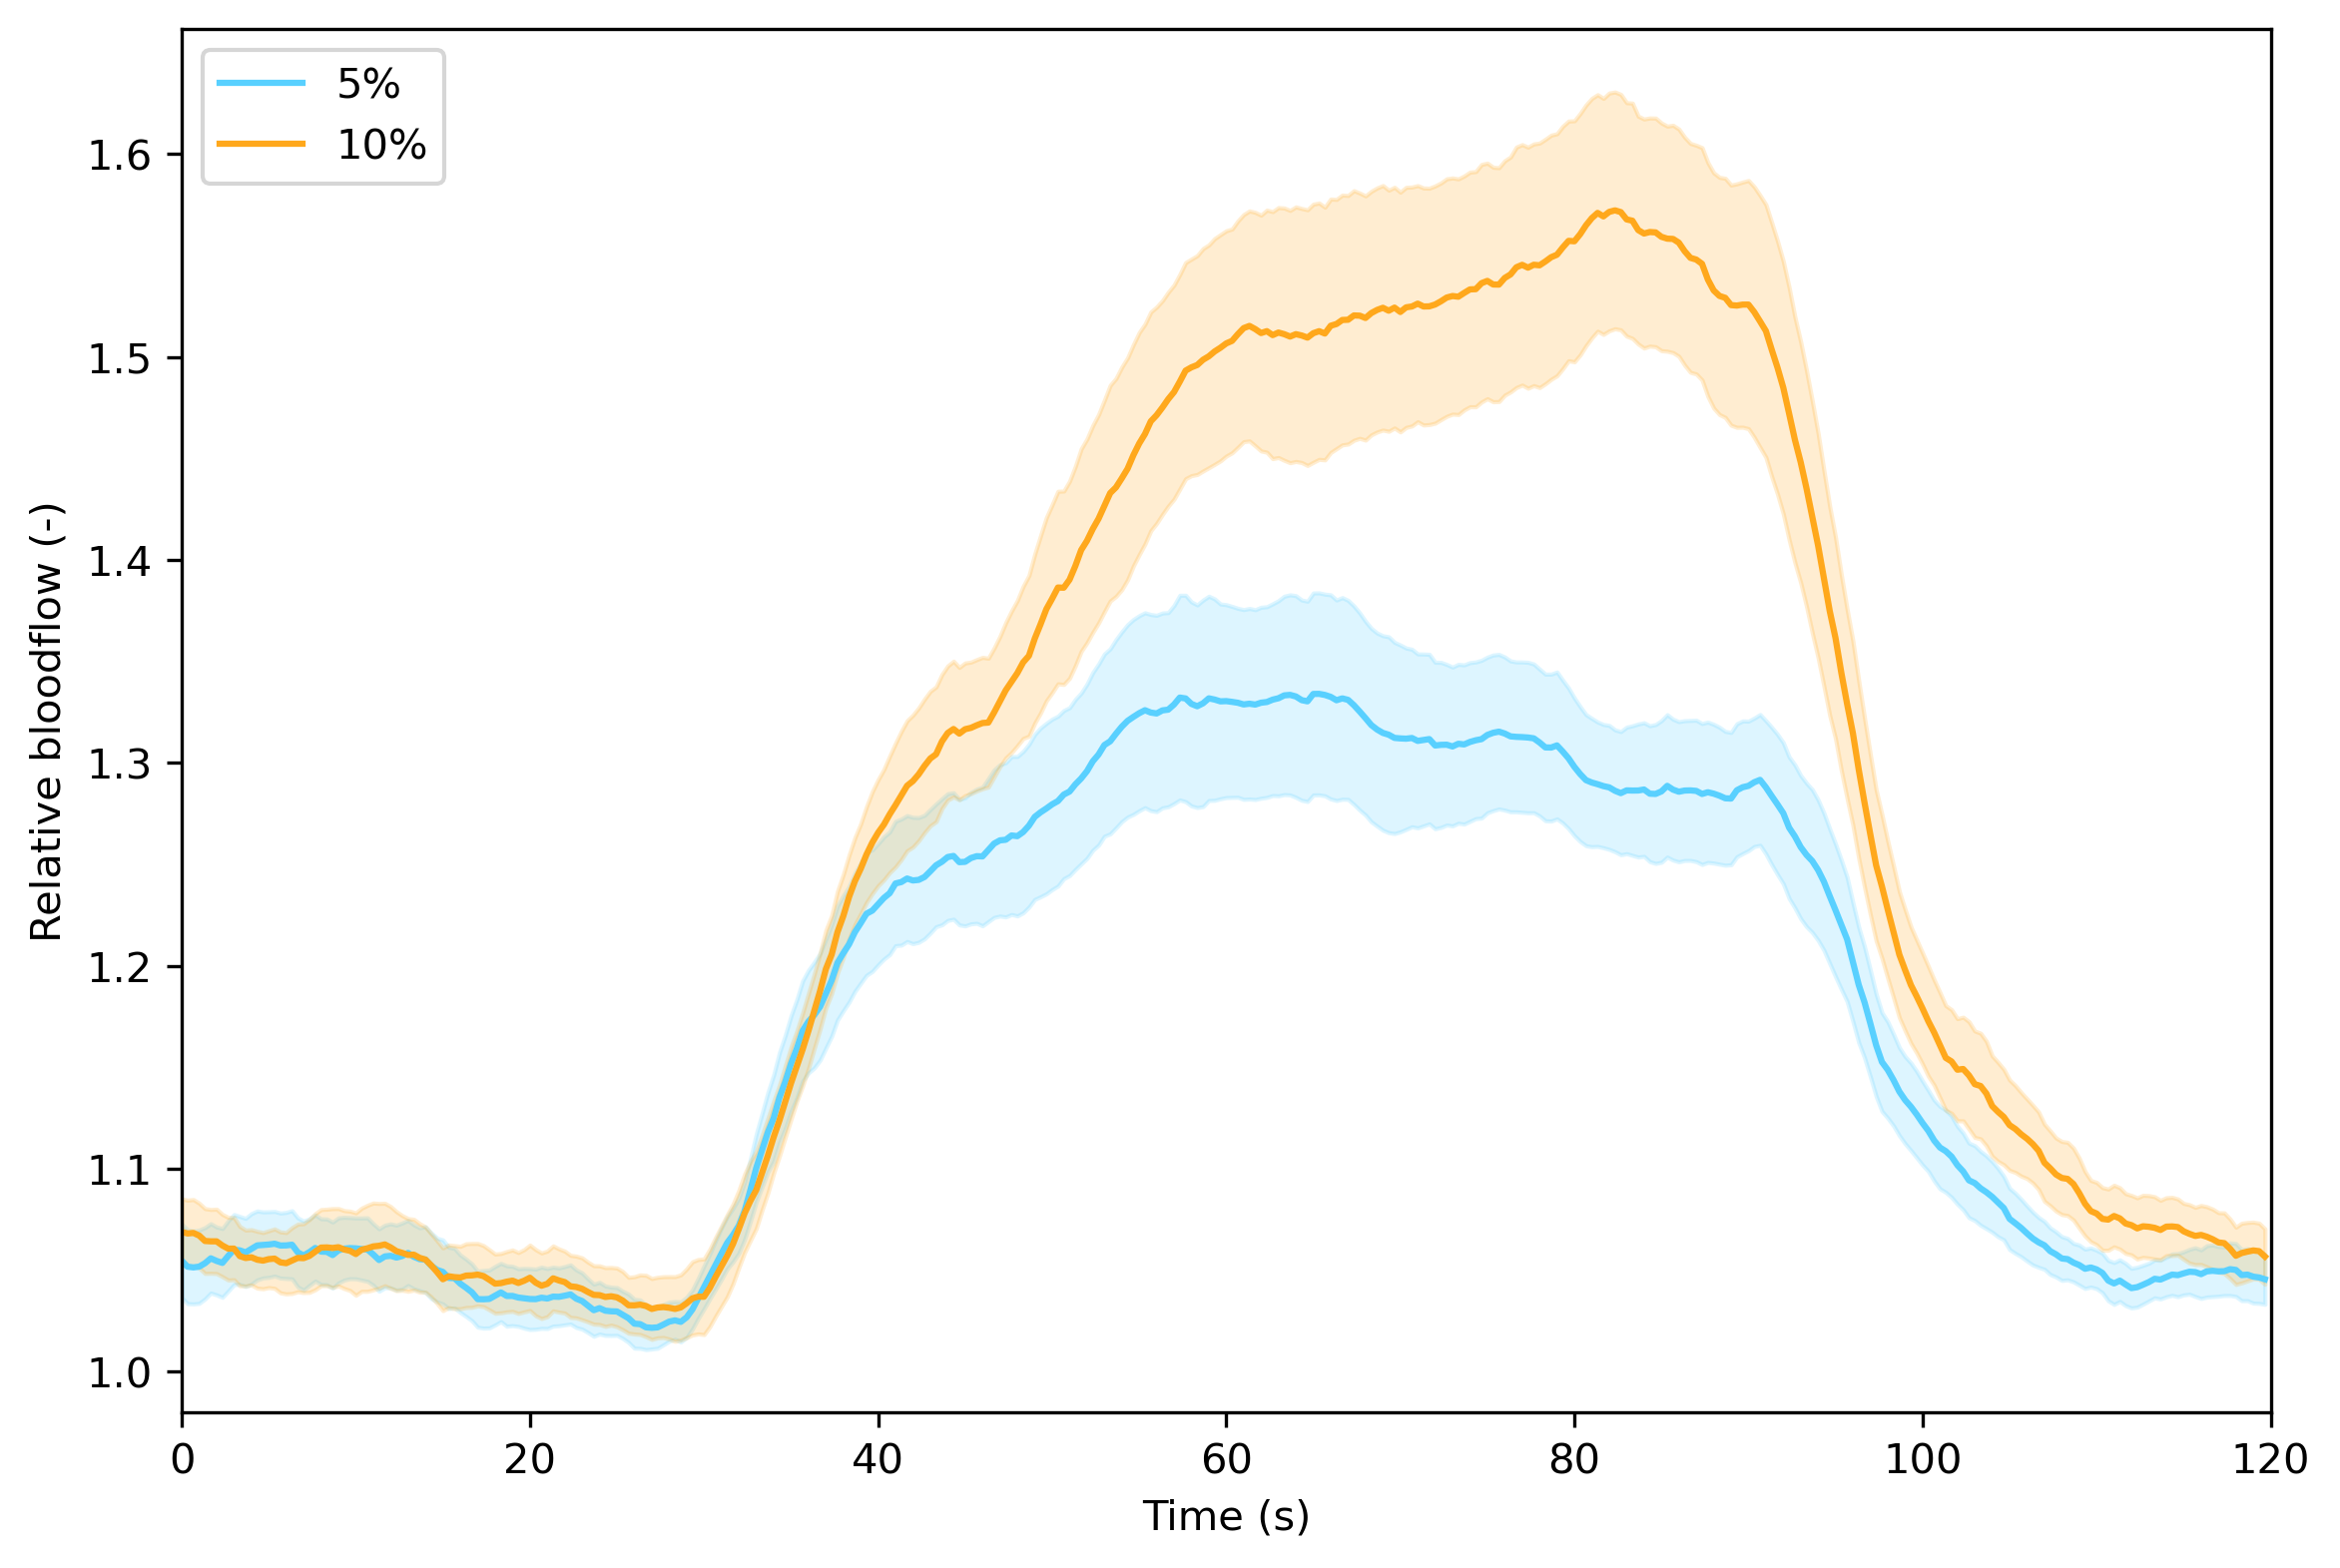

In [12]:
fig,ax = plt.subplots(figsize = (9,6),dpi=300)

avgk5 = np.mean(tau_avg5,axis=0)

# Calculate the SEM along axis=0
semk5 = np.std(tau_avg5, axis=0, ddof=1) / np.sqrt(len(tau_avg5))

x_values5 = np.arange(360)

# Plot the mean values as a line plot
plt.plot(x_values5, avgk5, label='5%', color=colors['blue'])

# Add a shaded area to represent the standard deviation
plt.fill_between(x_values5, avgk5 - semk5, avgk5 + semk5, alpha=0.2, color=colors['blue'])

avgk10 = np.mean(tau_avg10,axis=0)

# Calculate the SEM along axis=0
semk10 = np.std(tau_avg10, axis=0, ddof=1) / np.sqrt(len(tau_avg10))

x_values10 = np.arange(360)

# Plot the mean values as a line plot
plt.plot(x_values10, avgk10, label='10%', color=colors['orange'])

# Add a shaded area to represent the standard deviation
plt.fill_between(x_values10, avgk10 - semk10, avgk10 + semk10, alpha=0.2, color=colors['orange'])

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Relative bloodflow (-)')
plt.xlim([0,360])
plt.xticks([0,60,120,180,240,300,360], [0,20,40,60,80,100,120])
#plt.title('Mean Responses of 5% and 10% CO2 challenges')
plt.legend(loc='upper left')

# Show the plot
#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/K_5_10.svg')
plt.show()

T-statistic: -3.483143549978488, P-value: 0.0013835282814144173


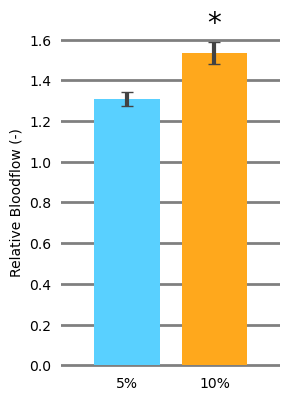

In [67]:
from scipy.stats import ttest_ind, sem # Import sem for standard error of the mean
import matplotlib.pyplot as plt
import numpy as np

k5 = []
k10 = []
for i in range(18):
    k5.append(np.mean(tau_avg5[i,180:270]))
    k10.append(np.mean(tau_avg10[i,180:270]))

# Perform two-sample t-test
t_stat, p_value = ttest_ind(k5, k10)

# Print t-statistic and p-value
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Create a barplot
labels = ['5%', '10%']
means = [np.mean(k5), np.mean(k10)]
errors = [sem(k5), sem(k10)] # Use sem instead of std

# Figure adjustments for aesthetics
plt.figure(figsize=(3, 4)) # Make the figure square and smaller
width = 0.3  # Make bars narrower

# Adjust bar positions to be closer to each other
positions = [0,0.4]

alpha = 0.05 # Common significance level
if p_value < alpha:
    # Choose a position to place the star, adjust y value as needed
    star_position = max(means) + max(errors) + 0.05 # Adjust this based on your data scale
    plt.text(0.4 , star_position, '*', fontsize=20, ha='center')

# Customization for bar and error bar appearance
bar_properties = {
    'linewidth': 2,        # Width of the bar border
    'color': [colors['blue'], colors['orange']],  # Bar fill color
    'capsize': 4,          # Cap size for error bars
    'yerr': errors,        # Error values
    'error_kw': {'elinewidth': 3, 'ecolor': colors['black']},
    'zorder': 3  # Ensure bars are plotted over the grid
}  # Error bar properties


plt.grid(axis='y', linestyle='-', linewidth=2, color='black', alpha=0.5)
plt.bar(positions, means, width, **bar_properties)


#plt.bar(positions, means, width, yerr=errors, capsize=5, color=[colors['blue'], colors['red']])
plt.xticks(positions, labels) # Set custom x-ticks to correspond to the labels
plt.ylabel('Relative Bloodflow (-)')
plt.tight_layout() # Optional: may help with fitting everything neatly into the figure
plt.gca().spines['top'].set_visible(False)  # Remove the top spine
plt.gca().spines['right'].set_visible(False)  # Remove the right spine
plt.gca().spines['bottom'].set_visible(False)  # Optionally, remove the bottom spine
plt.gca().spines['left'].set_visible(False)  # Optionally, remove the left spine
plt.ylim([-0.01,1.61])
plt.xlim([-0.3,0.7])

plt.tick_params(left=False, bottom=False)  # Hide ticks
plt.show()

# Test linéarité

In [340]:
avg5 = np.mean(hb_avg5,axis=0)
avg10 = np.mean(hb_avg10,axis=0)

In [341]:
avg5k = np.mean(tau_avg5,axis=0)
avg10k = np.mean(tau_avg10,axis=0)

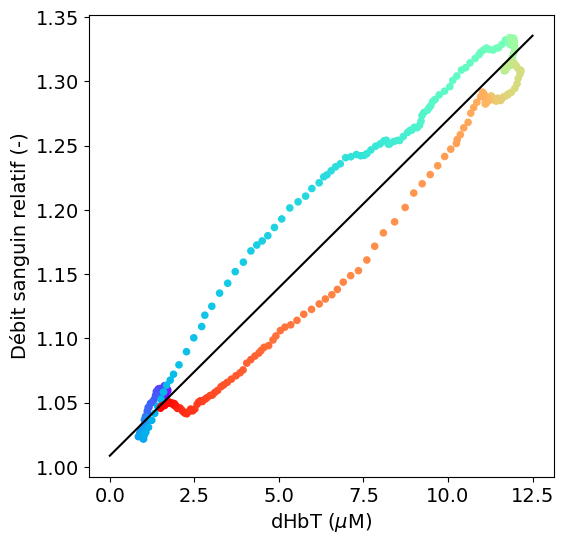

In [348]:
# Calculate the number of points in each array
n_points = len(avg5)  # Assuming avg5 and avgk5 have the same length
n_points10 = len(avg10)  # Assuming avg10 and avgk10 have the same length

# Generate a sequence of colors
colors5 = plt.cm.rainbow(np.linspace(0, 1, n_points))
colors10 = plt.cm.rainbow(np.linspace(0, 1, n_points10))
plt.figure(figsize=(6,6))
# Scatter plot with smaller points and rainbow color for avg5 vs. avgk5
plt.scatter(avg5, avg5k, color=colors5, s=20) #, edgecolors=colors['black'], linewidth=1)  # `s` controls the size of the points


# Scatter plot with smaller points and rainbow color for avg10 vs. avgk10
#plt.scatter(avg10, avg10k, color=colors10, s=10)  # Same for this scatter plot

# Fitting linear regression for avg5 vs. avgk5
coeffs = np.polyfit(avg5, avg5k, 1)  # Fit a 1st degree polynomial (linear) model
poly = np.poly1d(coeffs)  # Create polynomial function
x = np.linspace(0,12.5,200)
y = coeffs[0]*x + coeffs[1]
plt.plot(x, y, color='black')

plt.xlabel('dHbT ($\mu$M)',fontsize=14)
plt.ylabel('Débit sanguin relatif (-)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim([0,12.5])
#plt.ylim([1,1.35])

#plt.show()
plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/hbt_vs_speckle_5.svg')

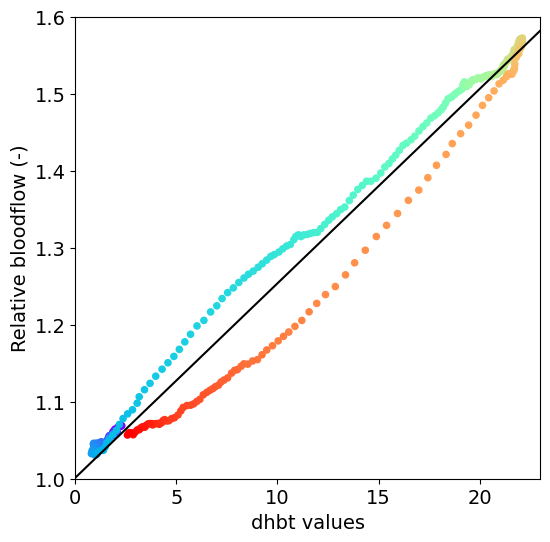

In [271]:
# Calculate the number of points in each array
n_points = len(avg5)  # Assuming avg5 and avgk5 have the same length
n_points10 = len(avg10)  # Assuming avg10 and avgk10 have the same length

# Generate a sequence of colors
colors5 = plt.cm.rainbow(np.linspace(0, 1, n_points))
colors10 = plt.cm.rainbow(np.linspace(0, 1, n_points10))
plt.figure(figsize=(6,6))
# Scatter plot with smaller points and rainbow color for avg5 vs. avgk5
#plt.scatter(avg5, avg5k, color=colors5, s=10)  # `s` controls the size of the points

# Scatter plot with smaller points and rainbow color for avg10 vs. avgk10
plt.scatter(avg10, avg10k, color=colors10, s=20)  # Same for this scatter plot

# Fitting linear regression for avg5 vs. avgk5
coeffs = np.polyfit(avg10, avg10k, 1)  # Fit a 1st degree polynomial (linear) model
x = np.linspace(0,23,200)
y = coeffs[0]*x + coeffs[1]
plt.plot(x, y, color='black')

plt.xlabel('dhbt values', fontsize=14)
plt.ylabel('Relative bloodflow (-)', fontsize=14)
plt.xlim([0,23])
plt.ylim([1.0,1.6])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/hbt_vs_speckle_10.svg')
plt.show()

In [210]:
# Calculate the differences between consecutive elements
delta_avg5 = np.diff(avg5)
delta_avg5k = np.diff(avg5k)

# Calculate derivative: central difference method for interior points
# For the boundary points, forward or backward difference can be used
derivatives = np.empty_like(avg5)

# Use forward difference for the first point
derivatives[0] = delta_avg5k[0] / delta_avg5[0]

# Use central difference for the middle points
derivatives[1:-1] = (delta_avg5k[1:] + delta_avg5k[:-1]) / (delta_avg5[1:] + delta_avg5[:-1])

# Use backward difference for the last point
derivatives[-1] = delta_avg5k[-1] / delta_avg5[-1]

# derivatives now contains the approximate derivative of avg5k with respect to avg5

# Stim fig presentation

In [29]:
response = np.mean(new_arr[:,0,:], axis=0)
response.shape

(2250,)

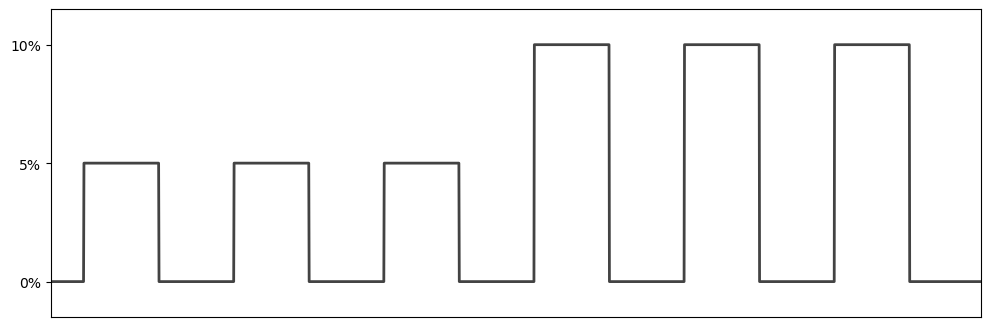

In [66]:
fig,ax = plt.subplots(figsize=(12,4))
CVR_stim = np.zeros(response.shape)
CVR_stim[blocks[0][0]:blocks[0][1]] = 1
CVR_stim[blocks[1][0]:blocks[1][1]] = 1
CVR_stim[blocks[2][0]:blocks[2][1]] = 1
CVR_stim[blocks[3][0]:blocks[3][1]] = 2
CVR_stim[blocks[4][0]:blocks[4][1]] = 2
CVR_stim[blocks[5][0]:blocks[5][1]] = 2
plt.xticks([])
plt.yticks([0, 1, 2], ['0%', '5%', '10%'])
plt.xlim([0,2230])
plt.ylim([-0.3,2.3])
plt.plot(CVR_stim, linewidth=2, color=colors['black'])

plt.savefig("/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/CVR_stim.svg")
plt.show()


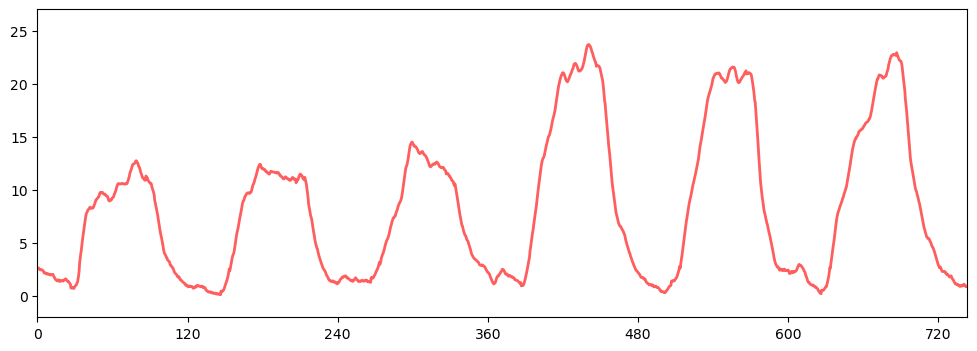

In [36]:
fig,ax = plt.subplots(figsize=(12,4))
plt.plot(response, linewidth=2, color=colors['red'])
plt.xticks([0,360,720,1080,1440,1800,2160], [0,120,240,360,480,600,720])
#plt.yticks([])
plt.xlim([0,2230])
plt.ylim([-2,27])
plt.savefig("/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/hbt_response_axis.svg")
plt.show()

# R^2 distribution

In [424]:
relative_tau2 = np.zeros((dataset2.shape[0], dataset2.shape[2]))
for i in range(dataset2.shape[0]):
    baseline = baseline_minfilter(dataset2[i,1,:])
    mean_min = np.mean(baseline)
    relative_tau2[i,:] = dataset2[i,1,:] / mean_min

In [425]:
other_tau_avg5 = np.zeros((42,360))
for i in range(dataset2.shape[0]):
    other_tau_avg5[6*i] = relative_tau2[i,blocks[0][0]-90:blocks[0][1]+90]
    other_tau_avg5[6*i + 1] = relative_tau2[i,blocks[1][0]-90:blocks[1][1]+90]
    other_tau_avg5[6*i + 2] = relative_tau2[i,blocks[2][0]-90:blocks[2][1]+90]
    other_tau_avg5[6*i + 3] = relative_tau2[i,blocks[3][0]-90:blocks[3][1]+90]
    other_tau_avg5[6*i + 4] = relative_tau2[i,blocks[4][0]-90:blocks[4][1]+90]
    other_tau_avg5[6*i + 5] = relative_tau2[i,blocks[5][0]-90:blocks[5][1]+90]

In [426]:
other_hb_avg5 = np.zeros((42,360))
for i in range(dataset2.shape[0]):
    other_hb_avg5[6*i] = dataset2[i,0,blocks[0][0]-90:blocks[0][1]+90]
    other_hb_avg5[6*i + 1] = dataset2[i,0,blocks[1][0]-90:blocks[1][1]+90]
    other_hb_avg5[6*i + 2] = dataset2[i,0,blocks[2][0]-90:blocks[2][1]+90]
    other_hb_avg5[6*i + 3] = dataset2[i,0,blocks[3][0]-90:blocks[3][1]+90]
    other_hb_avg5[6*i + 4] = dataset2[i,0,blocks[4][0]-90:blocks[4][1]+90]
    other_hb_avg5[6*i + 5] = dataset2[i,0,blocks[5][0]-90:blocks[5][1]+90]

In [428]:
new_tau5 = np.concatenate((tau_avg5, other_tau_avg5),axis=0)
new_hb5 = np.concatenate((hb_avg5, other_hb_avg5),axis=0)

# Age-dependent curves

In [437]:
old_tau5 = np.zeros((60,360))
old_hb5 = np.zeros((60,360))
for i in [0,1,2,3,4,5,9,10,11,12,13,14,18,19,20,21,22,23,24,25,26,27,28,29,42,43,44,45,46,47]:
    old_tau5[i] = new_tau5[i]
    old_hb5[i] = new_hb5[i]

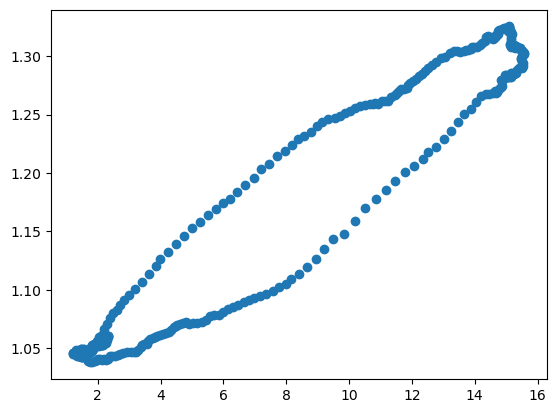

In [440]:
vect1 = np.zeros(360)
vect2 = np.zeros(360)
for i in [0,1,2,3,4,5,9,10,11,12,13,14,18,19,20,21,22,23,24,25,26,27,28,29,42,43,44,45,46,47]:
    vect1 += old_hb5[i]
    vect2 += old_tau5[i]
vect1 = vect1/30.0
vect2 = vect2/30.0
plt.scatter(vect1,vect2)

In [441]:
young_tau5 = np.zeros((60,360))
young_hb5 = np.zeros((60,360))
for i in [6,7,8,15,16,17,30,31,32,33,34,35,36,37,38,39,40,41,48,49,50,51,52,53,54,55,56,57,58,59]:
    young_tau5[i] = new_tau5[i]
    young_hb5[i] = new_hb5[i]

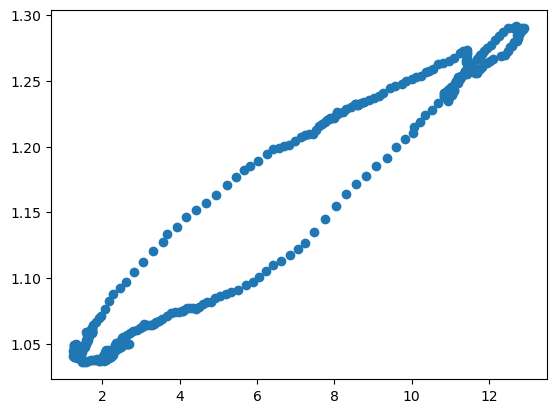

In [459]:
vect3 = np.zeros(360)
vect4 = np.zeros(360)
for i in [6,7,8,15,16,17,30,31,32,33,34,35,36,37,38,39,40,41,48,49,50,51,52,53,54,55,56,57,58,59]:
    vect3 += young_hb5[i]
    vect4 += young_tau5[i]
vect3 = vect3/30.0
vect4 = vect4/30.0
plt.scatter(vect3,vect4)

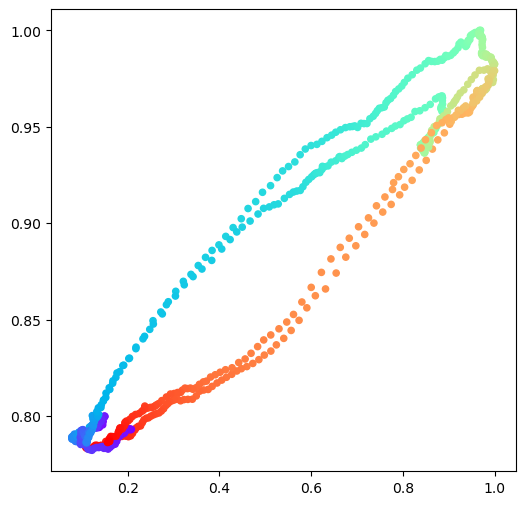

In [694]:
fig,ax=plt.subplots(figsize=(6,6))
plt.scatter(vect1/np.max(vect1),vect2/np.max(vect2), color=colors5, s=20)
plt.scatter(vect3/np.max(vect3),vect4/np.max(vect4)-0.02, color=colors5, s=20)

(1.0, 1.65)

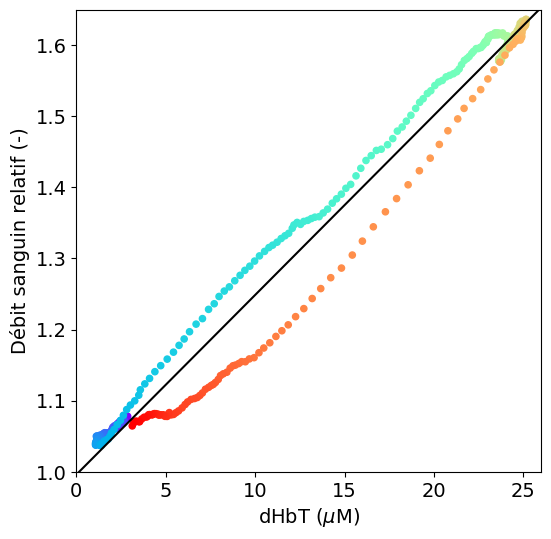

In [585]:
# Calculate the number of points in each array
n_points = len(avg5)  # Assuming avg5 and avgk5 have the same length
n_points10 = len(avg10)  # Assuming avg10 and avgk10 have the same length

# Generate a sequence of colors
colors5 = plt.cm.rainbow(np.linspace(0, 1, n_points))
colors10 = plt.cm.rainbow(np.linspace(0, 1, n_points10))
plt.figure(figsize=(6,6))

plt.scatter(mhb10, mtau10, color=colors10, s=20)  # Same for this scatter plot

# Fitting linear regression for avg5 vs. avgk5
coeffs = np.polyfit(mhb10, mtau10, 1)  # Fit a 1st degree polynomial (linear) model
poly = np.poly1d(coeffs)  # Create polynomial function
x = np.linspace(0,26,200)
y = coeffs[0]*x + coeffs[1]
plt.plot(x, y, color='black')

plt.xlabel('dHbT ($\mu$M)',fontsize=14)
plt.ylabel('Débit sanguin relatif (-)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,26])
plt.ylim([1,1.65])

#plt.show()


In [347]:
new_tau5_mean = np.mean(new_tau5,axis=0)
new_hb5_mean = np.mean(new_hb5,axis=0)

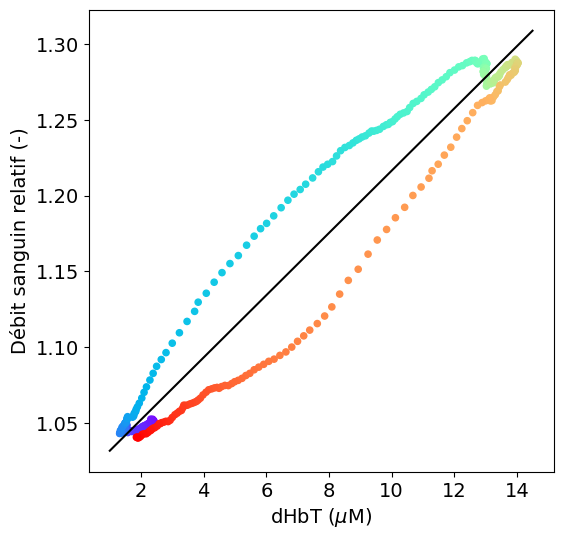

In [717]:
# Calculate the number of points in each array
n_points = len(new_tau5_mean)  # Assuming avg5 and avgk5 have the same length
n_points10 = len(new_tau5_mean)  # Assuming avg10 and avgk10 have the same length

# Generate a sequence of colors
colors5 = plt.cm.rainbow(np.linspace(0, 1, n_points))
colors10 = plt.cm.rainbow(np.linspace(0, 1, n_points10))
plt.figure(figsize=(6,6))
# Scatter plot with smaller points and rainbow color for avg5 vs. avgk5
#plt.scatter(avg5, avg5k, color=colors5, s=20)
plt.scatter(new_hb5_mean, new_tau5_mean, color=colors5, s=20)

#plt.plot(new_hb5_mean, new_tau5_mean) # edgecolors=colors['black'], linewidth=1)  # `s` controls the size of the points


# Scatter plot with smaller points and rainbow color for avg10 vs. avgk10
#plt.scatter(avg10, avg10k, color=colors10, s=10)  # Same for this scatter plot

# Fitting linear regression for avg5 vs. avgk5
coeffs = np.polyfit(new_hb5_mean, new_tau5_mean, 1)  # Fit a 1st degree polynomial (linear) model
poly = np.poly1d(coeffs)  # Create polynomial function
x = np.linspace(1,14.5,200)
y = coeffs[0]*x + coeffs[1]
plt.plot(x, y, color='black')

plt.xlabel('dHbT ($\mu$M)',fontsize=14)
plt.ylabel('Débit sanguin relatif (-)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim([0,14.5])
#plt.ylim([1,1.31])
plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/hbt_vs_speckle_5_n60.svg')

In [405]:
from scipy.stats import zscore

In [422]:
a = zscore(new_hb5_mean)
b = zscore(new_tau5_mean)

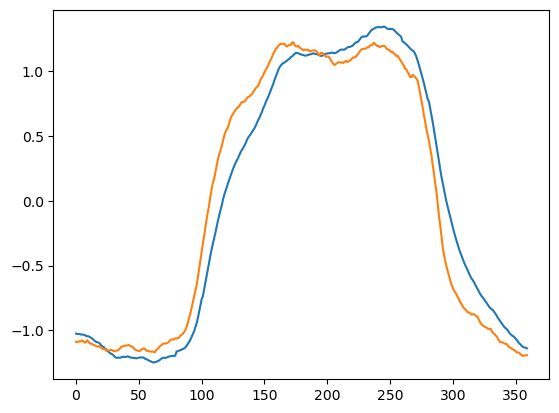

In [423]:
plt.plot(a)
plt.plot(b)

[]

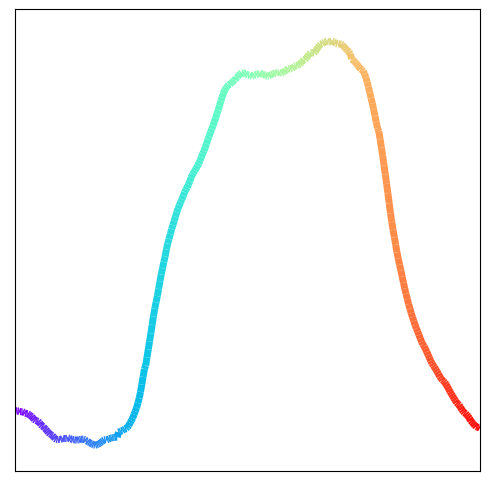

In [555]:
# Create the points array for the line segments
points = np.array([np.linspace(0, len(a), 360), new_hb5_mean]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Generate an array of indices scaled from 0 to 1, to use for the color mapping
indices = np.linspace(0, 1, len(points))

# Create a LineCollection
lc = LineCollection(segments, cmap='rainbow', norm=plt.Normalize(0, 1))
lc.set_array(indices)  # Use the indices for color mapping
lc.set_linewidth(5)

fig, ax = plt.subplots(figsize=(6,6))
ax.add_collection(lc)
ax.autoscale()
ax.set_xlim(np.min(np.linspace(0, len(a), 360)), np.max(np.linspace(0, len(a), 360)))
ax.set_ylim(0.5, new_hb5_mean.max() + 1)
ax.set_xticks([])
ax.set_yticks([])

#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/finished_figures/rainbow_hb5_mean.svg')

In [575]:
mhb10 = np.zeros(360)
mtau10 = np.zeros(360)
for i in [0,1,2,6,7,10,11,12,13,14,15,16,17]:
    mhb10 += hb_avg10[i]
    mtau10 += tau_avg10[i]
mhb10 = mhb10/13
mtau10 = mtau10/13

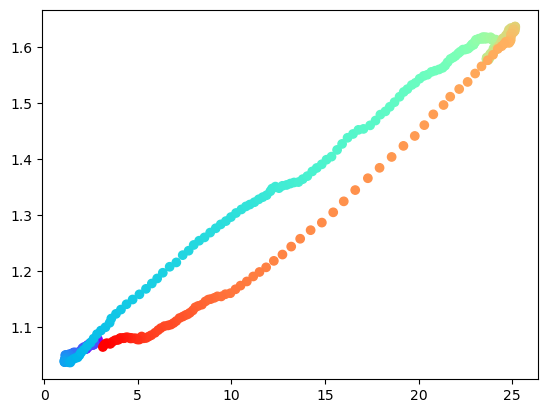

In [576]:
plt.scatter(mhb10,mtau10,color=colors10)

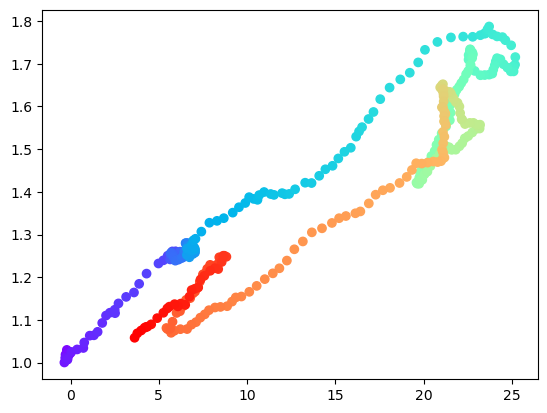

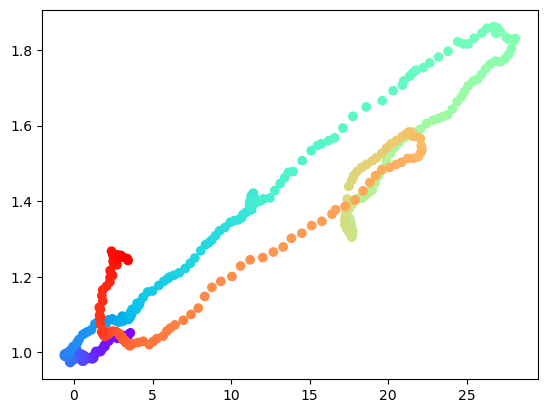

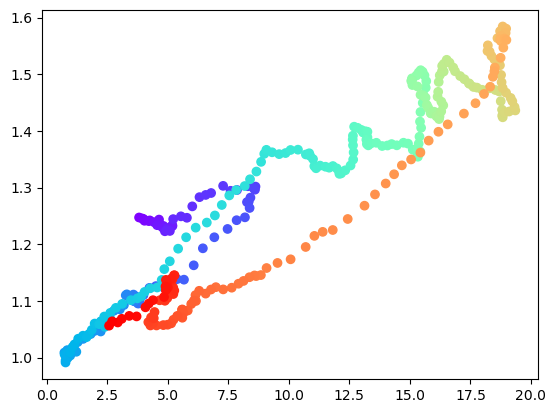

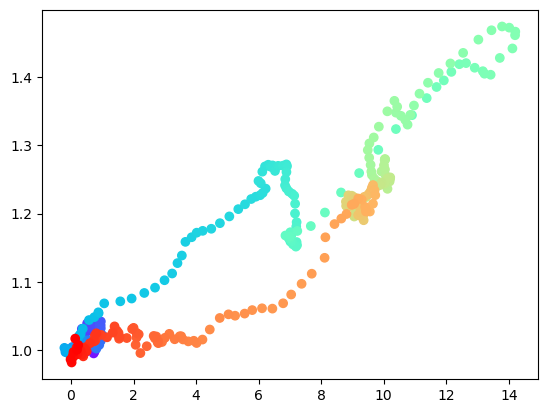

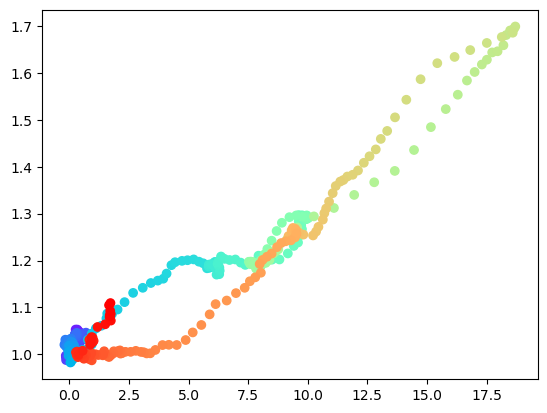

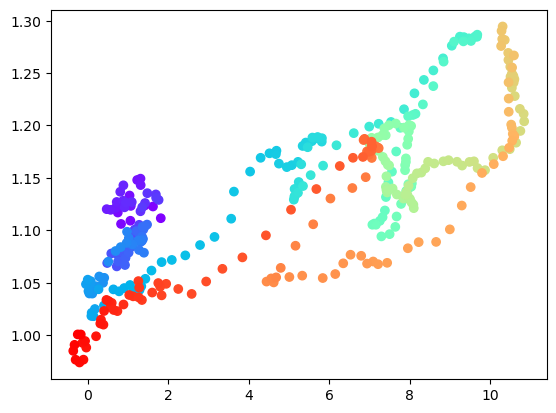

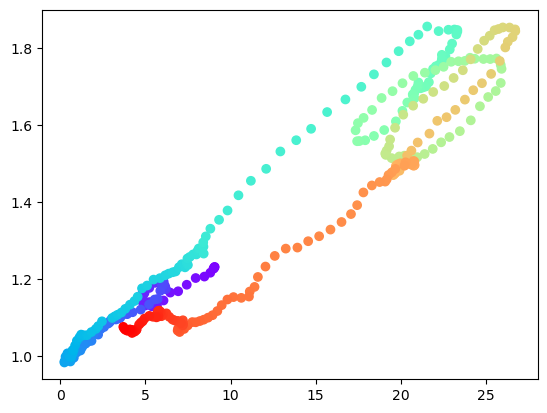

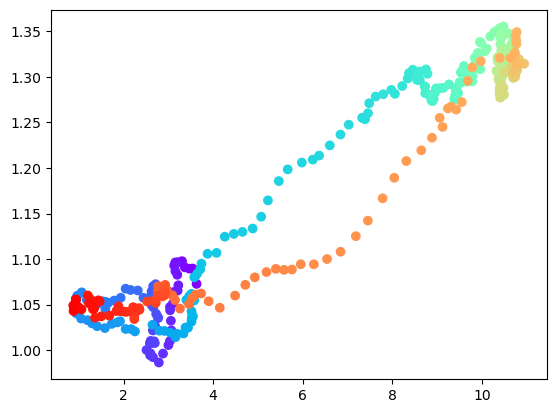

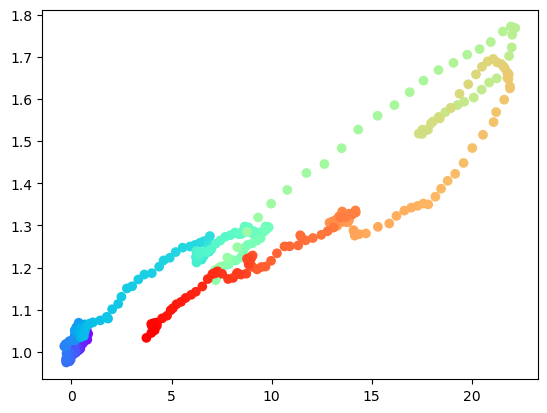

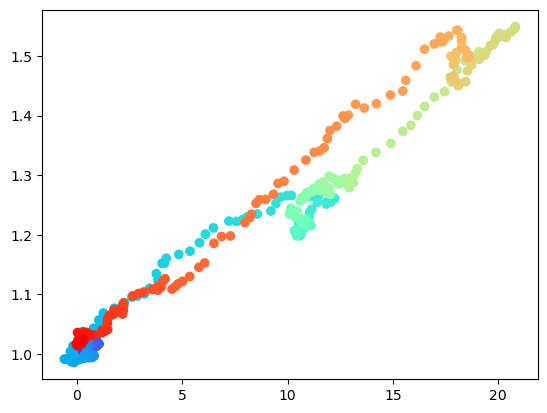

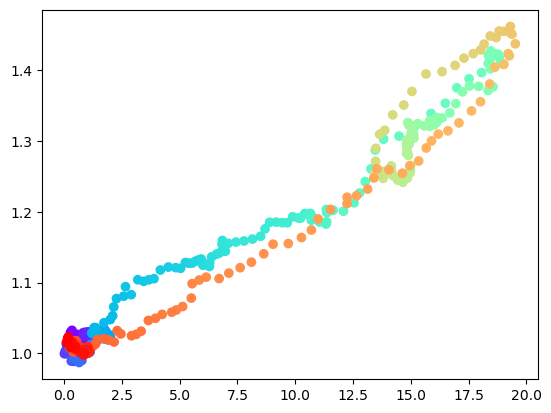

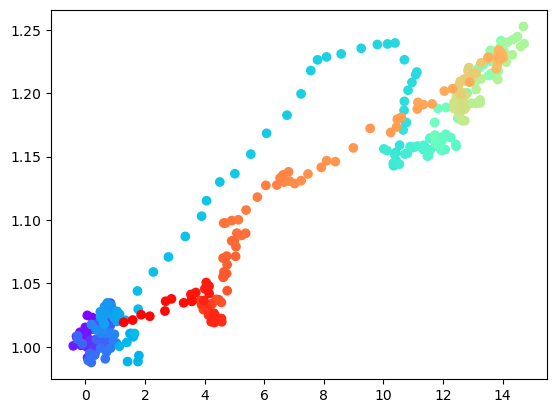

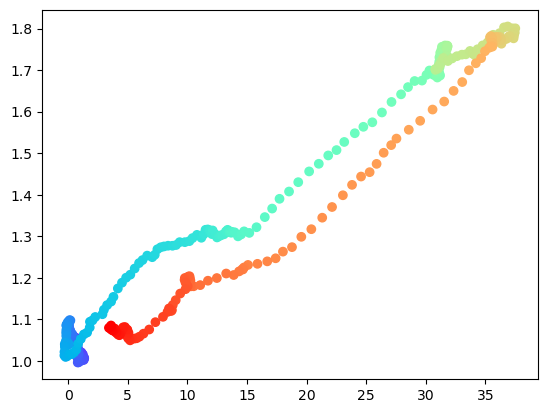

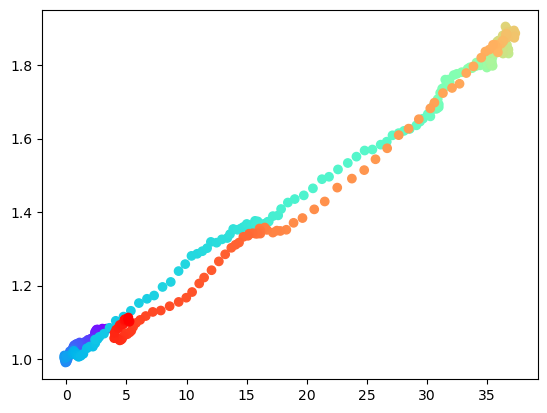

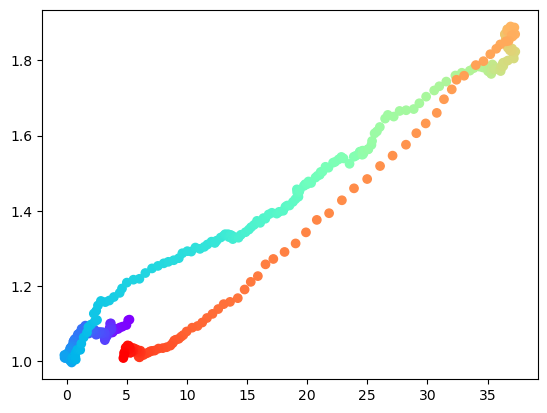

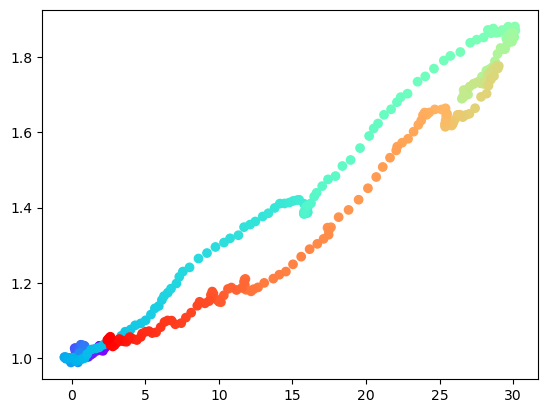

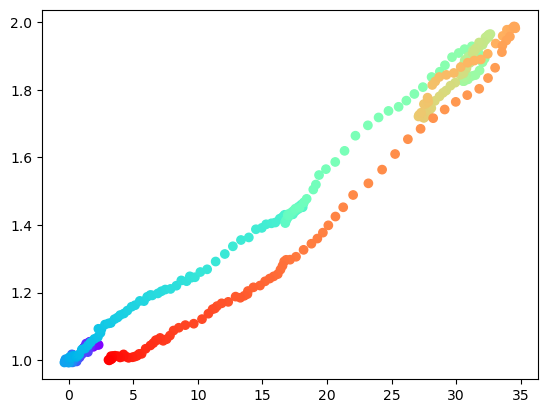

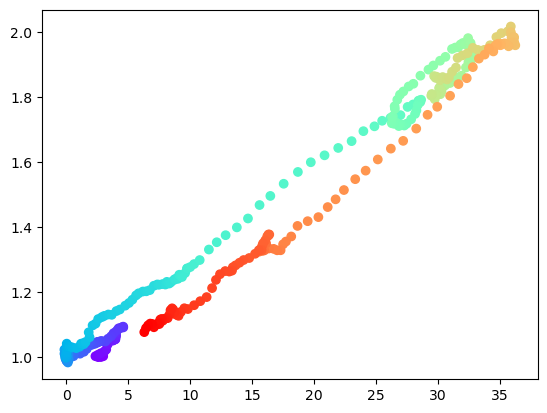

In [561]:
for i in range(18):
    plt.scatter(hb_avg10[i],tau_avg10[i], color=colors10)
    plt.show()

# Reshape old vs young mice

In [625]:
count_old = 0
count_young = 0
old_taus = np.zeros((30,360))
young_taus = np.zeros((30,360))
old_hbs = np.zeros((30,360))
young_hbs = np.zeros((30,360))
for i in range(60):
    if old_tau5[i,0] != 0.:
        old_taus[count_old , :] = old_tau5[i,:]
        old_hbs[count_old , :] = old_hb5[i,:]
        count_old += 1
    else:
        young_taus[count_young , :] = young_tau5[i,:]
        young_hbs[count_young , :] = young_hb5[i,:]
        count_young += 1


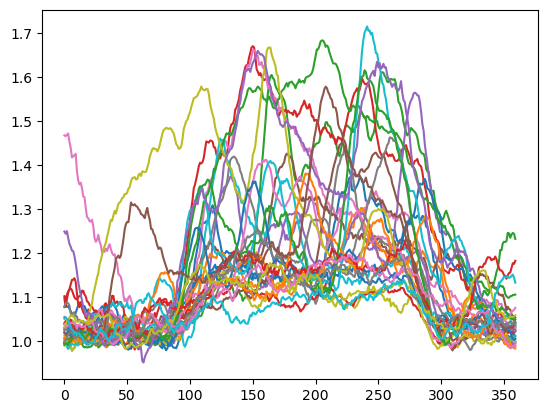

In [627]:
for i in range(30):
    plt.plot(young_taus[i])

# Pressure tests

Optimal cst: 94.02377494020146
Minimum absolute sum (approx. integral): 8.537881512893364e-10


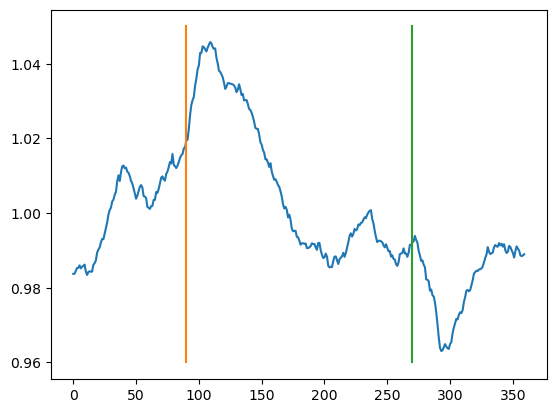

In [668]:
import numpy as np
from scipy import optimize

# Function to compute the sum (discrete integral approximation) of pressure for a specific cst
def sum_of_pressure(cst):
    rel_hb = (ymhb + cst) / cst
    pressure = ymtau / rel_hb**2
    return np.sum(pressure) - 360

# Optimization function to minimize the absolute value of the sum
def optimization_function(cst):
    return np.abs(sum_of_pressure(cst))

# Use scipy.optimize to find the optimal cst
# Note: x0 is the initial guess for cst
result = optimize.minimize(optimization_function, x0=100)

optimal_cst = result.x[0]
print("Optimal cst:", optimal_cst)
print("Minimum absolute sum (approx. integral):", result.fun)

plt.plot(ymtau/((ymhb+optimal_cst)/optimal_cst)**2)
plt.plot([90,90], [0.96,1.05])
plt.plot([270,270], [0.96,1.05])

In [ ]:
import numpy as np
from scipy import optimize

# Function to compute the sum (discrete integral approximation) of pressure for a specific cst
def sum_of_pressure(cst):
    rel_hb = (ymhb + cst) / cst
    pressure = ymtau / rel_hb**2
    return np.sum(pressure) - 360

# Optimization function to minimize the absolute value of the sum
def optimization_function(cst):
    return np.abs(sum_of_pressure(cst))

# Use scipy.optimize to find the optimal cst
# Note: x0 is the initial guess for cst
result = optimize.minimize(optimization_function, x0=100)

optimal_cst = result.x[0]
print("Optimal cst:", optimal_cst)
print("Minimum absolute sum (approx. integral):", result.fun)

plt.plot(ymtau/((ymhb+optimal_cst)/optimal_cst)**2)
plt.plot([90,90], [0.96,1.05])
plt.plot([270,270], [0.96,1.05])

# Brain map display

In [70]:
datapath = '/Volumes/DDE_Chouine/_CVR_Dataset/S6/Dataset/CVR_M38_S6/Hb_data/dHbT.tif'
img_stack = tiff.imread(datapath)
hb_stack = crop(img_stack, squared=True)

(-7.6177520751953125, 17.17530059814453)

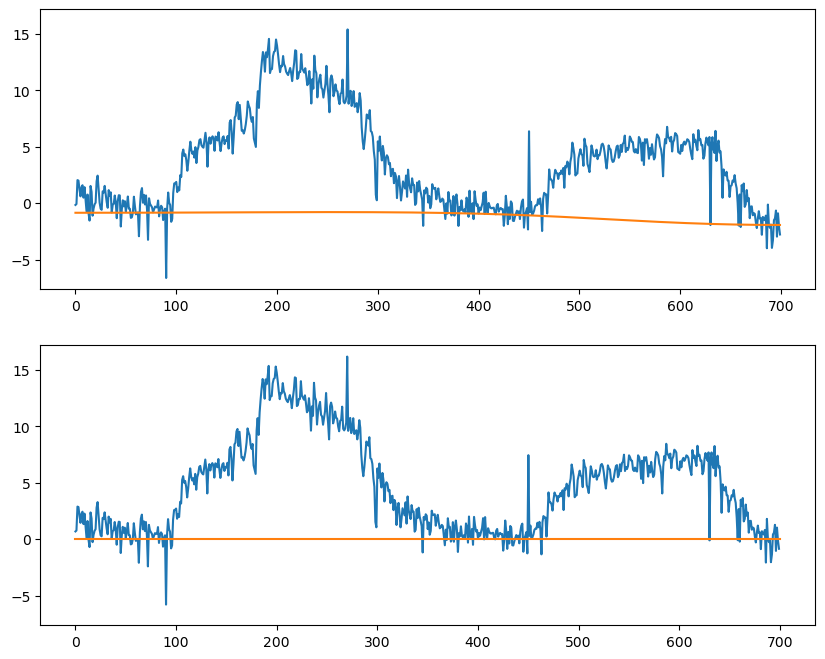

In [71]:
global_signal = np.mean(hb_stack,axis=(1,2))
baseline_sub = baseline_minfilter(global_signal, window=300, sigma1=5, sigma2=100, debug=False)
fig, ax = plt.subplots(2,1,figsize=(10,8))
minimum = np.min(global_signal)
maximum = np.max(global_signal - baseline_sub)
ax[0].plot(global_signal)
ax[0].plot(baseline_sub)
ax[0].set_ylim([minimum-1,maximum+1])
ax[1].plot(global_signal - baseline_sub)
ax[1].plot([0,global_signal.shape[0]],[0,0])
ax[1].set_ylim([minimum-1,maximum+1])

In [72]:
frame_block_init = 500

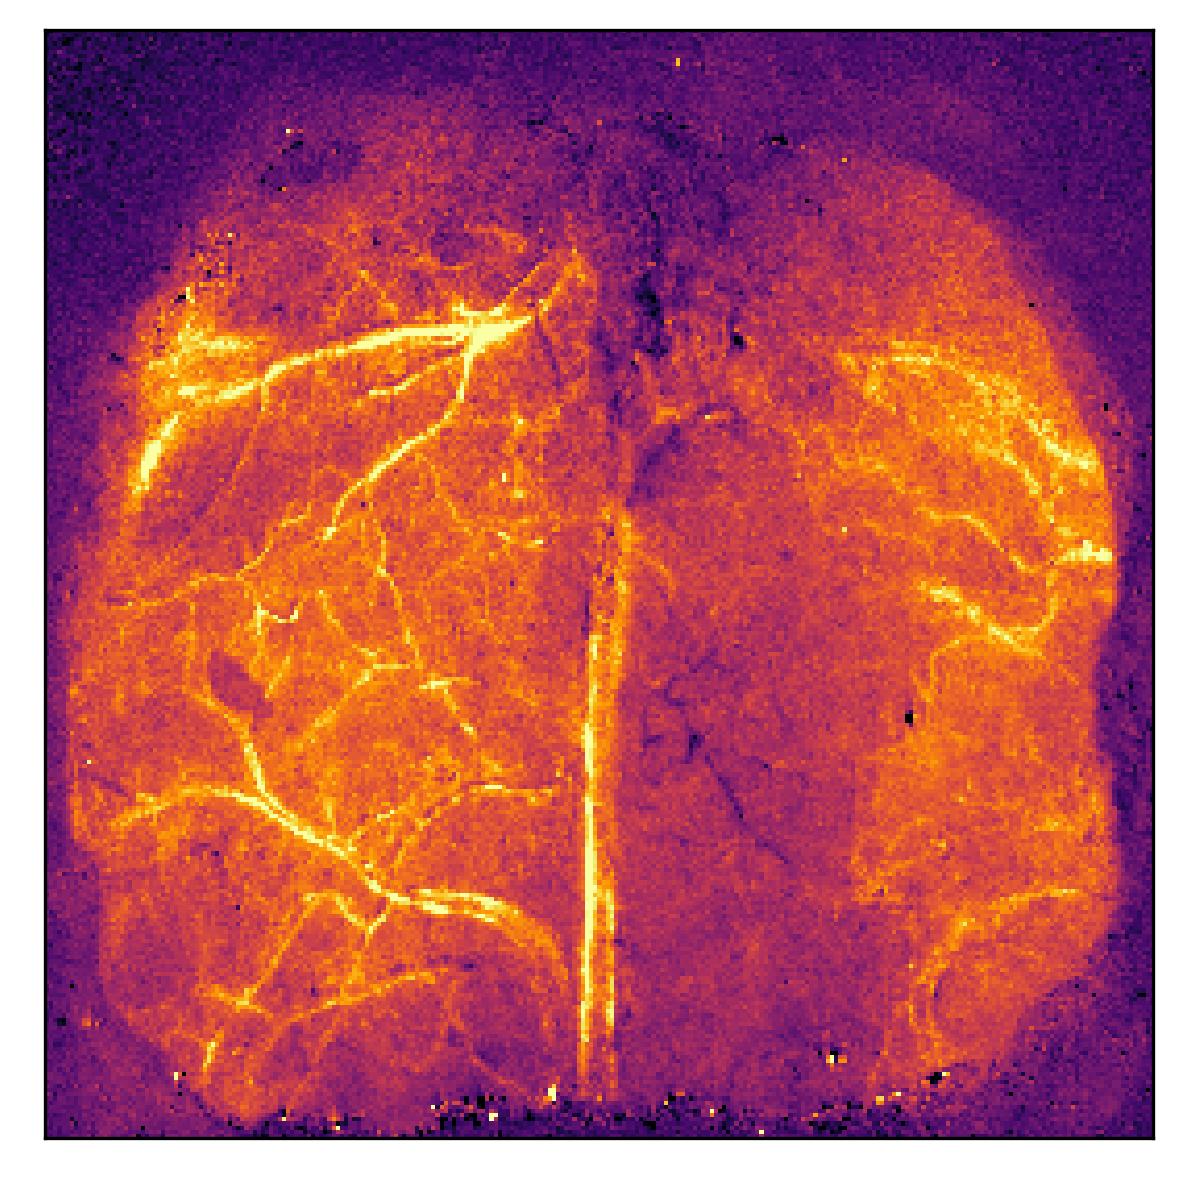

In [74]:
fig,ax = plt.subplots(dpi=300)
plt.imshow(np.mean(hb_stack[frame_block_init:frame_block_init+60],axis=0) - baseline_sub[frame_block_init], cmap='inferno', vmin=0, vmax=12)
plt.xticks([])
plt.yticks([])
#plt.colorbar()
plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/cvr_panel/{}.svg'.format(str(count)))


In [69]:
count += 1

In [6]:
sig = np.mean(new_arr , axis=0)

In [9]:
sig.shape

(2, 2250)

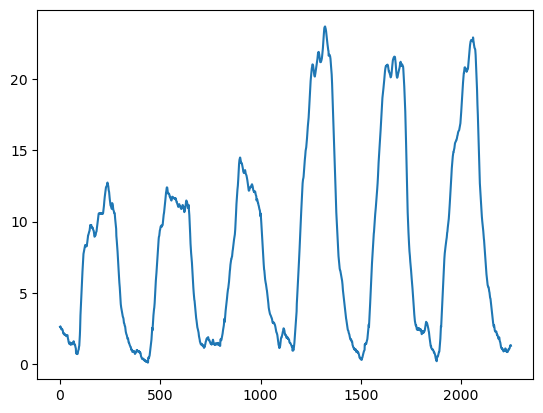

In [16]:
plt.plot(sig[0])

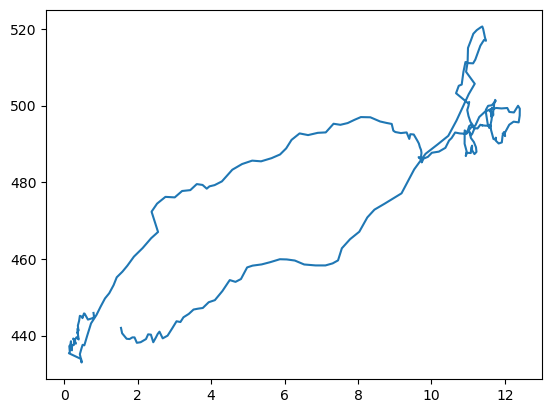

In [23]:
plt.plot(sig[0,400:700], sig[1,400:700]/(sig[0,400:700]+100))

# Bar charts for NOR

### Whole dataset barplot

In [181]:
mice_2week = ['M37', 'M38', 'M39', 'M42', 'M44', 'M45', 'M46', 'M47', 'M49', 'M50']
train_2week_1 = [65, 37, 47, 51, 38, 53, 20, 34, 32, 42]
train_2week_2 = [85, 32, 74, 47, 43, 41, 18, 42, 32, 29]
test_2week_1 = [15,6,1,5,5,5,2,10,2,2]
test_2week_2 = [8,3,3,5,3,7,3,9,4,6]   # New object


mice_2min = ['M37', 'M39', 'M44', 'M46', 'M49']
train_2min_1  = [51, 23, 52, 14, 44]
train_2min_2 = [59, 30, 48, 11, 33]
test_2min_1 = [4,7,3,1,6]
test_2min_2 = [9,27,9,0,21]   # New object

In [190]:
RB = ['#DFA5C4', '#9C9C9C'] #rose-blanc
OB = ['#FFB500', '#FF9000'] #orange-bleu
RM = ['#E273B0', '#603DB7'] #rose-mauve
BV = ['#A2C500', '#40B03E'] #bleu-vert

In [135]:
mouse_order = ['M37', 'M38', 'M39', 'M42', 'M44', 'M45', 'M46', 'M47', 'M49', 'M50']
#train2week_BV1 = [65, 37, 47, 51, 38, 53, 20, 34, 32, 42]
#train2week_BV2 = [85, 32, 74, 47, 43, 41, 18, 42, 32, 29]

In [173]:
test2week_BV = [15,6,1,5,5,5,2,10,2,2]
test2week_RB = [8,3,3,5,3,7,3,9,4,6]

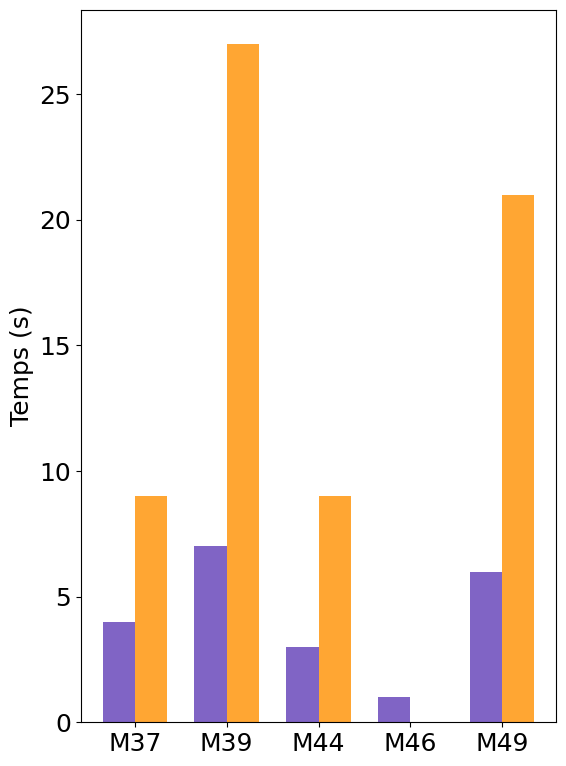

In [198]:
save = False
savepath = '/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/NOR/2min_testing.svg'

data1 = test_2min_1
color1 = RM[1]

data2 = test_2min_2
color2 = OB[1]

mice = mice_2min

plt.rcParams.update({'font.size': 18})
fig,ax=plt.subplots(figsize=(len(mice)*1.2 ,8))
index = np.arange(len(data1))
bar_width = 0.35
opacity = 0.8

# Plotting data
bar1 = ax.bar(index, data1, bar_width, alpha=opacity, color=color1)
bar2 = ax.bar(index + bar_width, data2, bar_width, alpha=opacity, color=color2)

# Adding some final touches
#ax.set_xlabel('Set')
ax.set_ylabel('Temps (s)', )
#ax.set_title('Training 10 minutes')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f'{mice[i]}' for i in range(len(data1))])
#ax.legend()

plt.tight_layout()

if save:
    plt.savefig(savepath)

### Group barplot

In [325]:
def NOR_measures(data_1, data_2, total_time, skip_ratio = 0.05, verbose=True):
    # Args are lists

    # Returns the percent exploration for each object in perc_exp as a tuple, and the discrimination ratio between
    # objects in disc_ratio
    
    
    time_spent_exploring = []
    perc_exp = []
    disc_ratio = []
    
    for i in range(len(data_1)):
        total_exploration = data_1[i] + data_2[i]
        if total_exploration/total_time > skip_ratio:
            perc_exp.append((data_1[i]/total_exploration , data_2[i]/total_exploration))
            disc_ratio.append((data_1[i] - data_2[i]) / total_exploration)
        else:
            if verbose:
                print(f"Skipped datapoint {i+1} because of insufficient exploration (skip_ratio = {skip_ratio})")
    
    
    return perc_exp, disc_ratio 

def NOR_mean_sem(perc_exp):
    # arg is list of tuples
    
    # Returns two tuples (mean, sem) for each object
    
    # Initialize the arrays with the correct size and type to hold the values.
    values_1 = np.zeros(len(perc_exp))
    values_2 = np.zeros(len(perc_exp))

    # Fill the arrays with the corresponding values from perc_exp tuples.
    for i in range(len(perc_exp)):
        values_1[i] = perc_exp[i][0]
        values_2[i] = perc_exp[i][1]
    
    # Calculate the mean for both arrays.
    mean_1 = np.mean(values_1)
    mean_2 = np.mean(values_2)
    
    # Calculate the standard error of the mean (SEM) for both arrays.
    sem_1 = np.std(values_1, ddof=1) / np.sqrt(len(values_1))  # ddof=1 for sample standard deviation
    sem_2 = np.std(values_2, ddof=1) / np.sqrt(len(values_2))  # ddof=1 for sample standard deviation
    
    means = (mean_1, mean_2)
    sems = (sem_1, sem_2)
    values = np.array([values_1, values_2])

    # Return the calculated means and SEMs.
    return values, means, sems

In [330]:
perc_exp, disc_ratio = NOR_measures(test_2min_1, test_2min_2, 120)
values, means, sems = NOR_mean_sem(perc_exp)

Skipped datapoint 4 because of insufficient exploration (skip_ratio = 0.05)


0.0014698403211298719


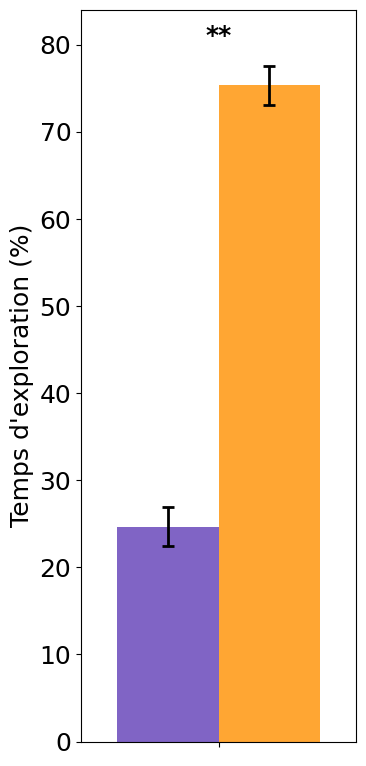

In [287]:
from scipy.stats import ttest_rel

save = False
savepath2 = '/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/NOR/results_2min.svg'

plt.rcParams.update({'font.size': 18})

fig,ax=plt.subplots(figsize=(4,8))
index = 1
bar_width = 0.35
opacity = 0.8

# Adjusted means and SEMs for plotting (multiplied by 100 for percentage)
adjusted_means = [mean * 100 for mean in means]
adjusted_sems = [sem * 100 for sem in sems]

# Plotting data
bar1 = ax.bar(index, adjusted_means[0], bar_width, alpha=opacity,  capsize=4, yerr= adjusted_sems[0] , error_kw={'elinewidth':2, 'capthick':2}, color = RM[1])
bar2 = ax.bar(index + bar_width, adjusted_means[1], bar_width, alpha=opacity, capsize=4 , error_kw={'elinewidth':2, 'capthick':2}, yerr=adjusted_sems[1], color = OB[1])

# Reconducting the paired t-test here to include it in the plotting logic
_, p_value = ttest_rel(values[0,:], values[1,:])
print(p_value)


# Determine significance level and annotate accordingly
sig_marker = ""
if p_value < 0.001:
    sig_marker = "***"  # Highly significant
elif p_value < 0.01:
    sig_marker = "**"   # Very significant
elif p_value < 0.05:
    sig_marker = "*"    # Significant

    
if sig_marker:
    max_height = max(adjusted_means[0] + adjusted_sems[0], adjusted_means[1] + adjusted_sems[1])
    ax.text(index + bar_width / 2, max_height + 2, sig_marker, ha='center', va='bottom', fontsize=18,weight="bold")


# Adding some final touches
#ax.set_xlabel('Set')
ax.set_ylabel("Temps d'exploration (%)")
#ax.set_title('Somme des temps')
ax.set_xlim([0.7,1.65])
ax.set_xticklabels([])
ax.set_xticks([1.175],[''])
ax.set_ylim([0,84])
#ax.legend()

plt.tight_layout()

if save:
    plt.savefig(savepath2)

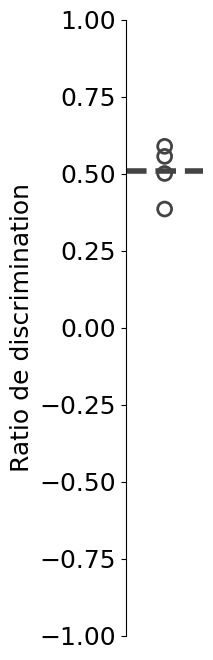

In [331]:
#diff_train_2week = np.array(train2week_BV2) - np.array(train2week_BV1)
# Correcting the code to work specifically with the diff_train2week data
#diff_train2week = [20, -5, 27, -4, 5, -12, -2, 8, 0, -13]
save = True
inverse = True
savepath3 = "/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/NOR/disc_ratio_2min.svg"

if inverse:
    adjusted_disc_ratio = -1*np.array(disc_ratio)
else:
    adjusted_disc_ratio = np.array(disc_ratio)

# Since we're plotting just one list now, we adjust the code accordingly
x_values = [0] * len(adjusted_disc_ratio)

# Creating the scatter plot for diff_train2week
fig, ax = plt.subplots(figsize=(1, 8))
ax.scatter(x_values, adjusted_disc_ratio, color=colors['black'], marker='o', edgecolors=colors['black'], linewidth=2, facecolors='none', s=100)

# Setting the y-axis labels directly as we're not calculating a difference between two sums here
#ax.set_yticks(sorted(diff_train2week))
#ax.set_yticklabels([f'{y}' for y in sorted(diff_train2week)])

# Removing x-axis marks and renaming the y-axis
ax.set_xticks([])
ax.set_ylabel("Ratio de discrimination")
ax.set_ylim([-1,1])

#ax.set_title('Vertical Scatter Plot of Differences')
plt.axhline(y=np.mean(adjusted_disc_ratio), color=colors['black'], linestyle='--', linewidth=4)  # Adding a line at y=0 for reference

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#plt.tight_layout()
#plt.show()

if save:
    plt.savefig(savepath3)

# Back to CVR, on check la différence entre les âges avec HbT

#### Test avec M34, M35 et M37  pendant S1 à S7 avec HbT seulement (car nous n'avons pas ir dans S1 à S4)

In [5]:
blocks = [(90,270), (450,630), (810, 990), (1170,1350), (1530,1710), (1890,2070)]

In [6]:
blocks5 = np.zeros((3,14,360))
blocks10 = np.zeros((3,14,360))

for i in range(blocks5.shape[1]):
    for j in range(3):
        blocks5[j,i,:] = M3435[i,blocks[0+j][0]-90:blocks[0+j][1]+90]
        blocks10[j,i,:] = M3435[i,blocks[3+j][0]-90:blocks[3+j][1]+90]
    
#     blocks5[6*i] = relative_tau2[i,blocks[0][0]-90:blocks[0][1]+90]
#     other_tau_avg5[6*i + 1] = relative_tau2[i,blocks[1][0]-90:blocks[1][1]+90]
#     other_tau_avg5[6*i + 2] = relative_tau2[i,blocks[2][0]-90:blocks[2][1]+90]
#     other_tau_avg5[6*i + 3] = relative_tau2[i,blocks[3][0]-90:blocks[3][1]+90]
#     other_tau_avg5[6*i + 4] = relative_tau2[i,blocks[4][0]-90:blocks[4][1]+90]
#     other_tau_avg5[6*i + 5] = relative_tau2[i,blocks[5][0]-90:blocks[5][1]+90]

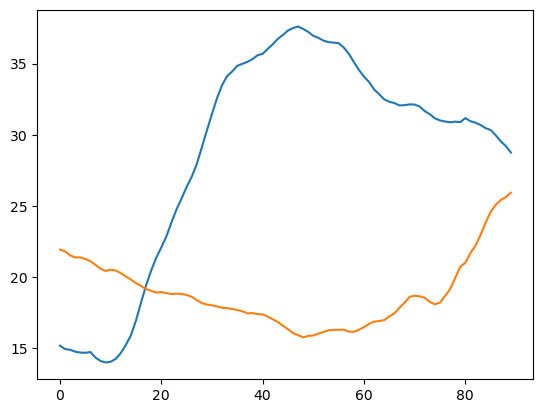

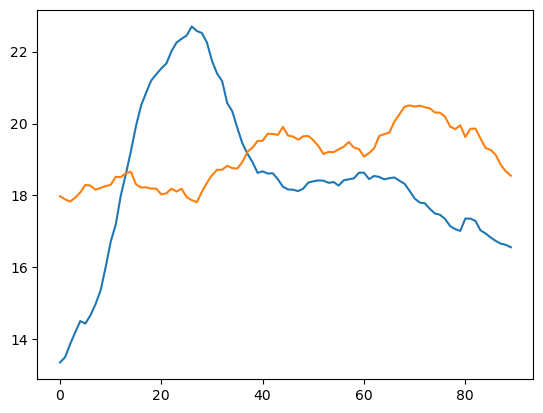

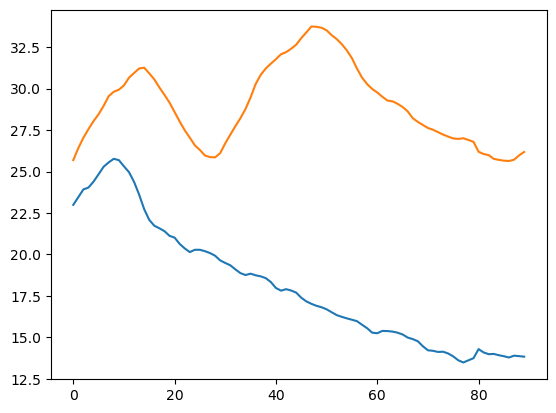

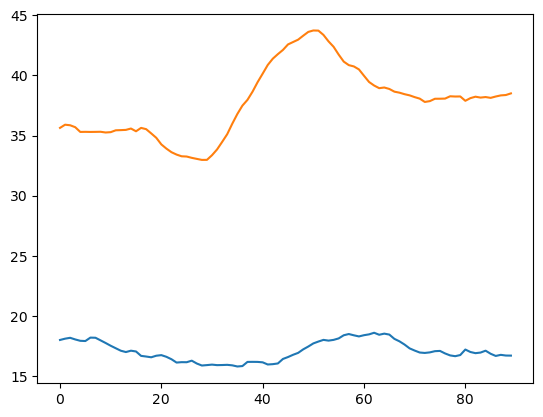

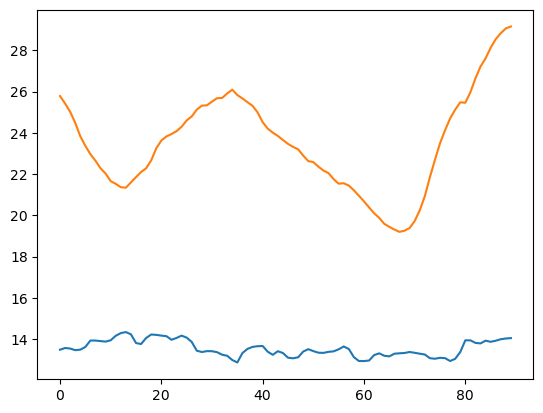

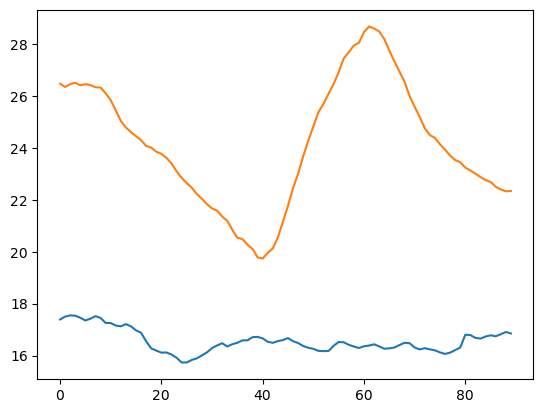

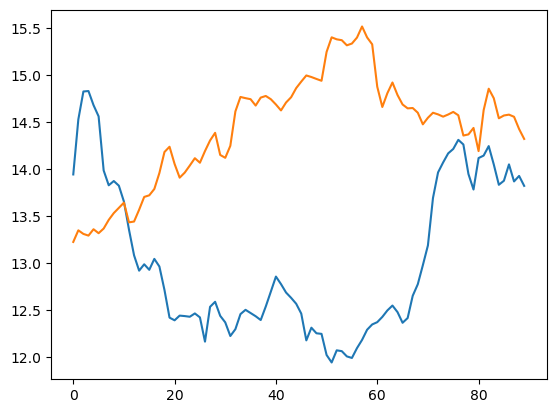

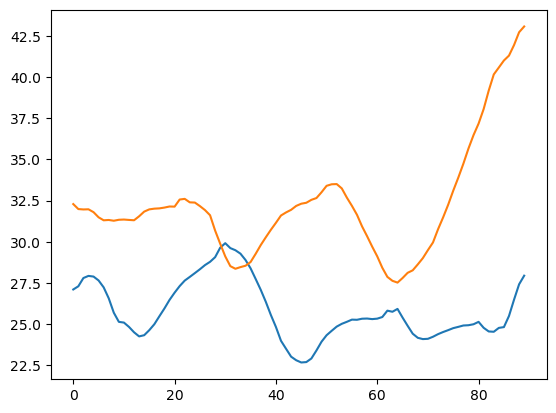

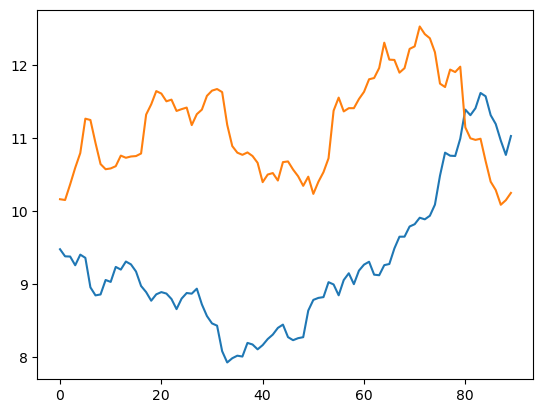

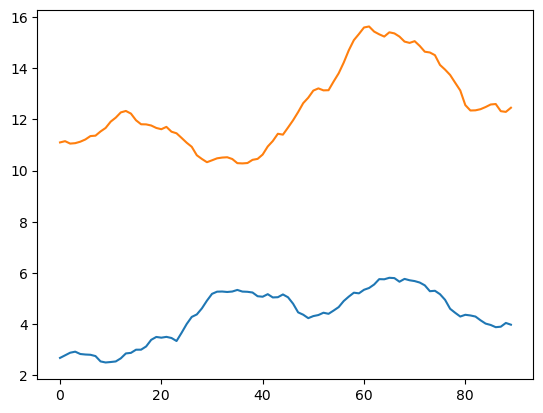

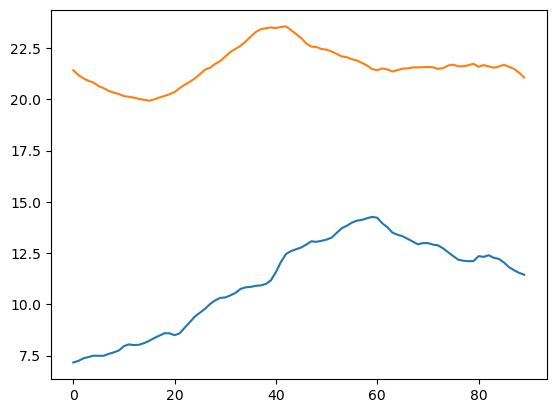

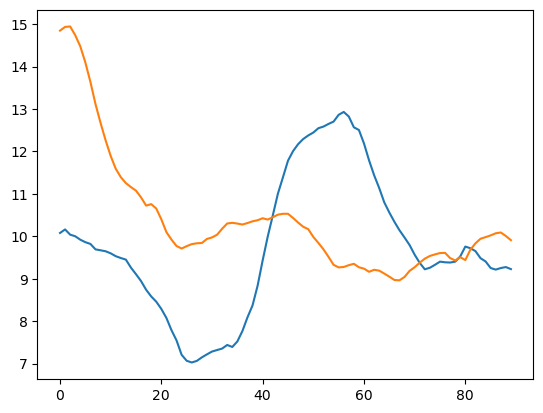

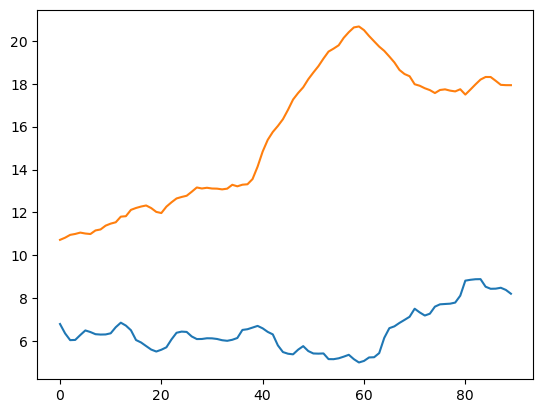

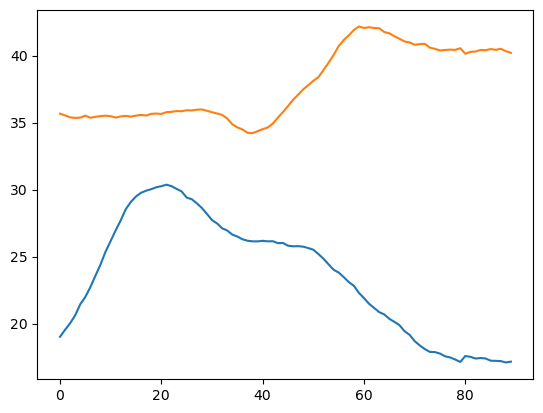

In [7]:
for i in range(blocks5.shape[1]):
    plt.plot(np.mean(blocks5[::3,i,180:270],axis=0))
    plt.plot(np.mean(blocks10[::3,i,180:270],axis=0))
    plt.show()

In [37]:
ten_five_ratio = np.zeros(blocks5.shape[1])

In [38]:
for i in range(blocks5.shape[1]):
    ten_five_ratio[i] = np.mean(np.mean(blocks10[:,i,190:260],axis=0) / np.mean(blocks5[:,i,190:260],axis=0))

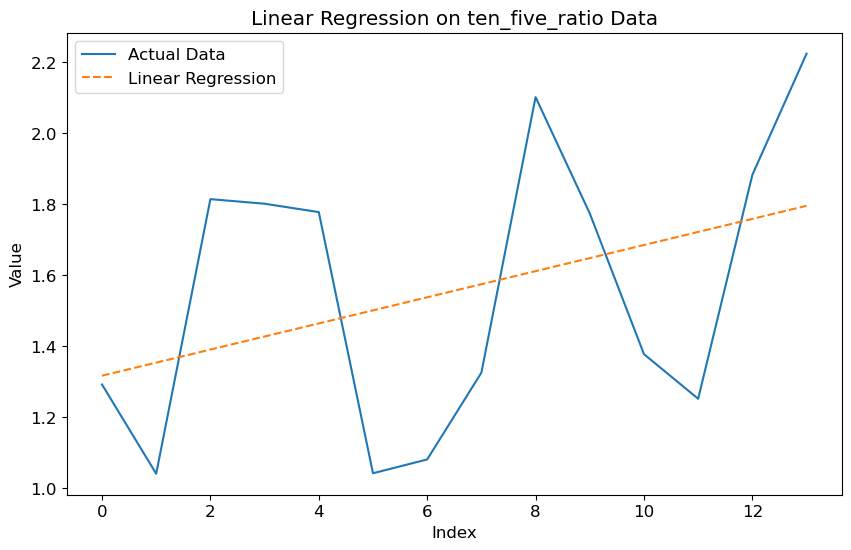

0.1484887770877934


In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Reshape for sklearn
X = np.arange(len(ten_five_ratio)).reshape(-1, 1)
y = ten_five_ratio.reshape(-1, 1)

# Linear regression
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
r_squared = model.score(X, y)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ten_five_ratio, label='Actual Data')
plt.plot(y_pred, label='Linear Regression', linestyle='--')
plt.legend()
plt.title('Linear Regression on ten_five_ratio Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

print(r_squared)

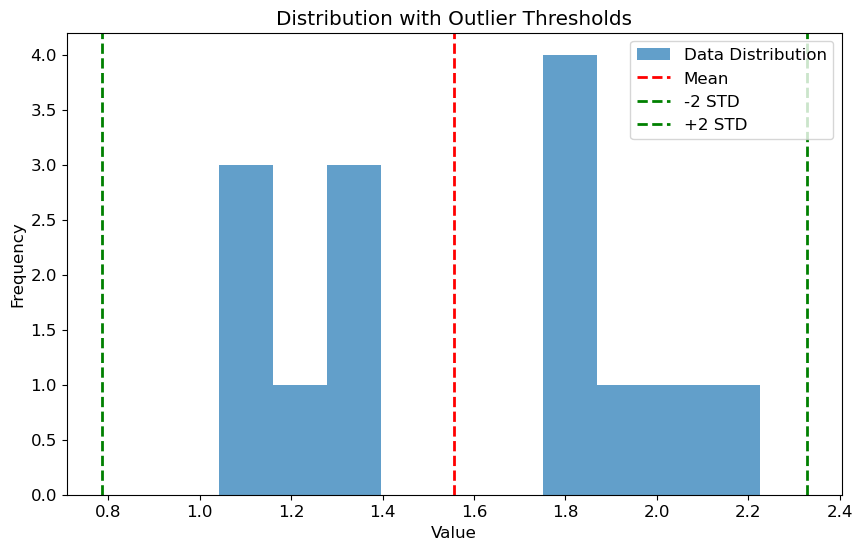

In [121]:
# Calculate mean and standard deviation for the 'ten_five_ratio' array
mean_value = np.mean(ten_five_ratio)
std_deviation = np.std(ten_five_ratio)

# Identifying outliers based on the mean and standard deviation (more than 2 standard deviations from the mean)
outliers = ten_five_ratio[(ten_five_ratio < mean_value - 2 * std_deviation) | (ten_five_ratio > mean_value + 2 * std_deviation)]

# Normal distribution based on values
plt.figure(figsize=(10, 6))
plt.hist(ten_five_ratio, bins=10, alpha=0.7, label='Data Distribution')
plt.axvline(mean_value, color='r', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(mean_value - 2 * std_deviation, color='g', linestyle='dashed', linewidth=2, label='-2 STD')
plt.axvline(mean_value + 2 * std_deviation, color='g', linestyle='dashed', linewidth=2, label='+2 STD')
plt.legend()
plt.title('Distribution with Outlier Thresholds')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [39]:
M34 = ten_five_ratio[::2]
M35 = ten_five_ratio[1::2]
#M37 = ten_five_ratio[2::3]

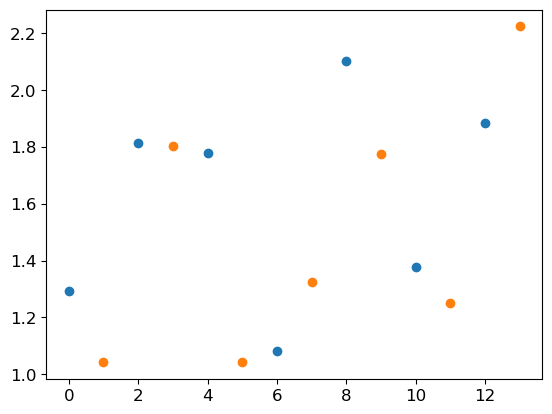

In [94]:
plt.scatter([0,2,4,6,8,10,12],M34)
plt.scatter([1,3,5,7,9,11,13],M35)
#plt.scatter([2,5,8,11,14,17,20],M37)

In [95]:
values = np.zeros((2,7))
values[0,:] = M34
values[1,:] = M35
#values[2,:] = M37

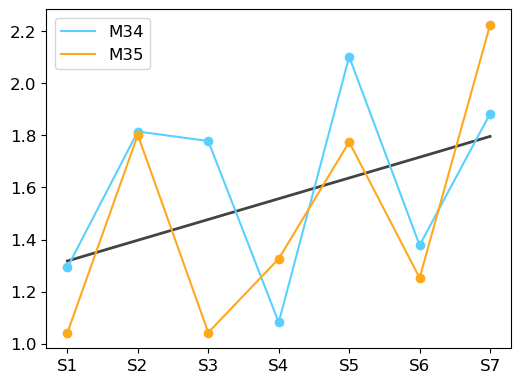

In [42]:
fig, ax = plt.subplots(figsize=(6,4.4))

plt.rcParams.update({'font.size': 12})

plt.plot(M34, color=colors['blue'], label="M34")
plt.plot(M35, color=colors['orange'], label="M35")
# plt.plot(M37, color=colors['green'], label="M37")
plt.plot(np.linspace(0, 6, 14), y_pred, color=colors['black'], linestyle='-', linewidth=2, zorder=1)
# plt.plot(mean_sessions, color=colors['black'], linewidth=2, label='Moyenne', alpha=0.8)

# Increase zorder for scatter plots
plt.scatter([0, 1, 2, 3, 4, 5, 6], M34[:7], color=colors['blue'], zorder=3)
plt.scatter([0, 1, 2, 3, 4, 5, 6], M35[:7], color=colors['orange'], zorder=3)
# plt.scatter([0, 1, 2, 3, 4, 5, 6], M37[:7], color=colors['green'], zorder=3)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7'])
plt.legend()

# Save the figure
plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/Age_CVR/M3435_S1S7_data_reg.svg')

In [36]:
plt.rcParams.update({'font.size': 12})

plt.plot(M34, color=colors['blue'], label = "M34")
plt.plot(M35, color=colors['orange'], label = "M35")
#plt.plot(M37, color=colors['green'], label = "M37")
plt.plot(np.linspace(0,6,14) , y_pred, color=colors['black'], linestyle='-', linewidth = 2)
#plt.plot(mean_sessions, color=colors['black'], linewidth=2, label = 'Moyenne', alpha=0.8)

plt.scatter([0,1,2,3,4,5,6],M34[:7], color=colors['blue'])
plt.scatter([0,1,2,3,4,5,6],M35[:7], color=colors['orange'])
#plt.scatter([0,1,2,3,4,5,6],M37[:7], color=colors['green'])


plt.xticks([0,1,2,3,4,5,6], ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7'])
plt.legend()

plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/Age_CVR/M3435_S1S7_data_reg.svg')

NameError: name 'M34' is not defined

In [123]:
young = ten_five_ratio[:8]
old = ten_five_ratio[8:]

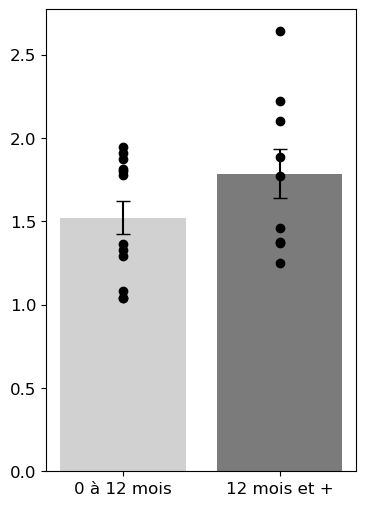

In [37]:
mean_y = np.mean(young)
std_y = np.std(young)
mean_o = np.mean(old)
std_o = np.std(old)

fig,ax=plt.subplots(figsize=(4,6))
# Data for plotting
categories = ['0 à 12 mois', '12 mois et +']
means = [mean_y, mean_o]
sems = [std_y/np.sqrt(12), std_o/np.sqrt(9)]

# Creating the bar chart
x = range(len(categories))
plt.bar(x, means, yerr=sems, capsize=5, alpha=0.7, color=[colors['gray'], colors['black']])
plt.scatter([0,0,0,0,0,0,0,0,0,0,0,0],young,color='black')
plt.scatter([1,1,1,1,1,1,1,1,1],old,color='black')
plt.xticks(x, categories)
#plt.ylabel('Values')

#plt.title('Mean Values with Standard Deviation')
plt.show()

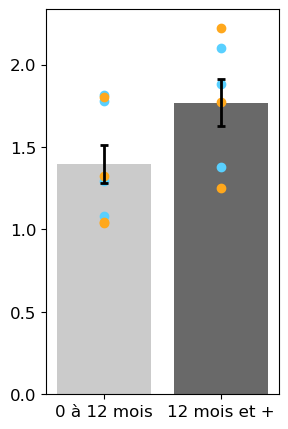

In [124]:

# Adjusting the bar chart to make error bars thicker and the small horizontal lines (caps) thicker but less wide
fig, ax = plt.subplots(figsize=(3, 5))


# Recalculate means and SEMs based on the new data
mean_y = np.mean(young)
std_y = np.std(young)
mean_o = np.mean(old)
std_o = np.std(old)
means = [mean_y, mean_o]
sems = [std_y / np.sqrt(len(young)), std_o / np.sqrt(len(old))]

# Define colors (assuming 'colors' dictionary is defined elsewhere, using direct color values here)
gray_color = colors['gray']
black_color = colors['black']

# Error bars adjustments
error_kw = {'capsize': 3, 'capthick': 2, 'elinewidth': 2, 'ecolor': 'black'}

# Plotting
x = range(len(categories))
bars = plt.bar(x, means, yerr=sems, alpha=0.8, color=[gray_color, black_color], error_kw=error_kw)
#plt.scatter(np.zeros(len(young)), young, facecolors='none', edgecolors='black')
#plt.scatter(np.ones(len(old)), old, facecolors='none', edgecolors='black')
plt.scatter([0,0,0,0,1,1,1],M34, color=colors['blue'])
plt.scatter([0,0,0,0,1,1,1],M35, color=colors['orange'])
#plt.scatter([0,0,0,0,1,1,1],M37, color=colors['green'])
plt.xticks(x, categories)

plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/Age_CVR/S1S7_data_barplot.svg')

In [40]:
from scipy.stats import ttest_ind

# Perform a t-test to compare the means of the two independent samples
t_stat, p_value = ttest_ind(young, old)

p_value

0.16166107416808256

In [305]:
blocks5.shape

(3, 24, 360)

In [284]:
blocks10.shape

(3, 24, 360)

##### p-value is worse (0.22) and does not look linear.

In [61]:
new_old = np.zeros(6)
new_young = np.zeros(8)
for i in range(4):
    new_young[2*i] = M34[i]
    new_young[2*i+1] =M35[i]
for j in range(3):
    new_old[2*j] = M34[j+4]
    new_old[2*j+1] = M35[j+4]

In [62]:
from scipy.stats import ttest_ind

# Perform a t-test to compare the means of the two independent samples
t_stat, p_value = ttest_ind(new_young, new_old)

p_value

0.08405534725232408

In [113]:
from scipy.stats import pearsonr

pearsonr(M34,M37)

PearsonRResult(statistic=0.21484003049084965, pvalue=0.6436347749354372)

In [116]:
M34_shuffled = np.copy(M34)
M35_shuffled = np.copy(M35)
correlations = []
for _ in range(1000):
    np.random.shuffle(M34_shuffled)
    np.random.shuffle(M35_shuffled)
    r = pearsonr(M34_shuffled,M35_shuffled)[0]
    correlations.append(r)

In [118]:
np.percentile(correlations,95) 

0.6829517205489269

(array([ 5., 12.,  3.,  9., 16., 15., 18., 42., 51., 38., 54., 41., 43.,
        46., 55., 52., 59., 51., 62., 50., 52., 43., 30., 34., 29., 27.,
        30., 18.,  7.,  8.]),
 array([-0.97910055, -0.91642873, -0.85375692, -0.79108511, -0.72841329,
        -0.66574148, -0.60306967, -0.54039785, -0.47772604, -0.41505423,
        -0.35238241, -0.2897106 , -0.22703878, -0.16436697, -0.10169516,
        -0.03902334,  0.02364847,  0.08632028,  0.1489921 ,  0.21166391,
         0.27433572,  0.33700754,  0.39967935,  0.46235117,  0.52502298,
         0.58769479,  0.65036661,  0.71303842,  0.77571023,  0.83838205,
         0.90105386]),
 <BarContainer object of 30 artists>)

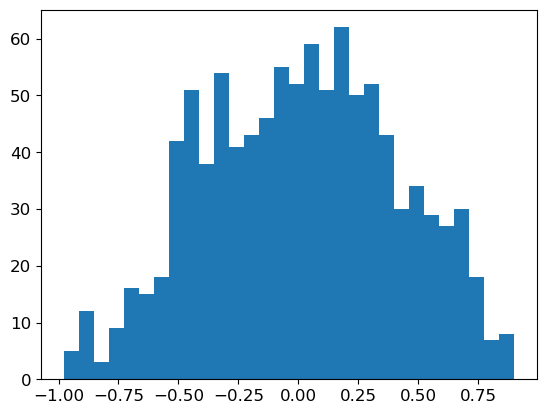

In [128]:
plt.hist(correlations, bins=30)

# Les tests sont pas plus corrélés entre eux que le hasard xoxo

# Amplitudes

In [29]:
five_mean.shape

(14, 360)

In [21]:
five_mean = np.mean(blocks5,axis=0)
ten_mean = np.mean(blocks10,axis=0)

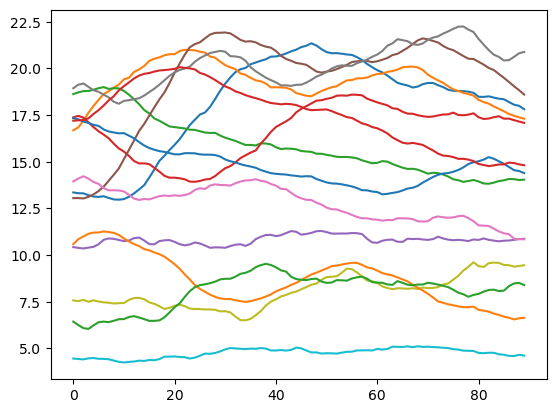

In [28]:
for i in range(five_mean.shape[0]):
    plt.plot(five_mean[i, 180:270])

In [32]:
five_amp = np.zeros(14)
ten_amp = np.zeros(14)
for i in range(14):
    five_amp[i] = np.mean(five_mean[i,180:270])
    ten_amp[i] = np.mean(ten_mean[i,180:270])

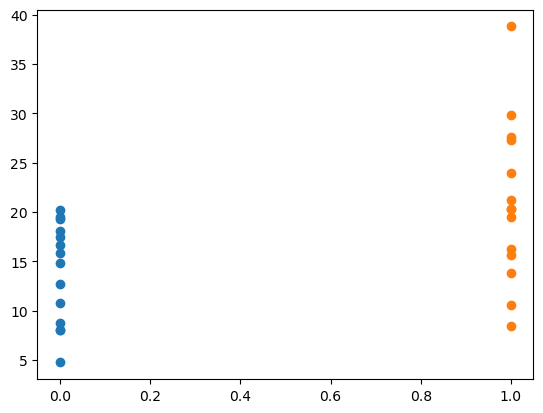

In [34]:
plt.scatter([0,0,0,0,0,0,0,0,0,0,0,0,0,0], five_amp)
plt.scatter([1,1,1,1,1,1,1,1,1,1,1,1,1,1], ten_amp)

([<matplotlib.axis.XTick at 0x7fb596b3cc40>,
 [Text(0, 0, 'S1'),
  Text(1, 0, 'S2'),
  Text(2, 0, 'S3'),
  Text(3, 0, 'S4'),
  Text(4, 0, 'S5'),
  Text(5, 0, 'S6'),
  Text(6, 0, 'S7')])

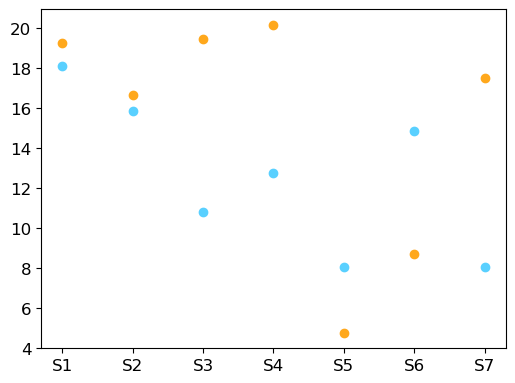

In [45]:
fig, ax = plt.subplots(figsize=(6,4.4))

plt.rcParams.update({'font.size': 12})

#plt.plot(M34, color=colors['blue'], label="M34")
#plt.plot(M35, color=colors['orange'], label="M35")
# plt.plot(M37, color=colors['green'], label="M37")
#plt.plot(np.linspace(0, 6, 14), y_pred, color=colors['black'], linestyle='-', linewidth=2, zorder=1)
# plt.plot(mean_sessions, color=colors['black'], linewidth=2, label='Moyenne', alpha=0.8)

# Increase zorder for scatter plots
plt.scatter([0, 1, 2, 3, 4, 5, 6], five_amp[::2], color=colors['blue'], zorder=3)
plt.scatter([0, 1, 2, 3, 4, 5, 6], five_amp[1::2], color=colors['orange'], zorder=3)
# plt.scatter([0, 1, 2, 3, 4, 5, 6], M37[:7], color=colors['green'], zorder=3)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7'])
#plt.legend()

# Save the figure
#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/Age_CVR/M3435_S1S7_data_reg.svg')

([<matplotlib.axis.XTick at 0x7fb596478160>,
 [Text(0, 0, 'S1'),
  Text(1, 0, 'S2'),
  Text(2, 0, 'S3'),
  Text(3, 0, 'S4'),
  Text(4, 0, 'S5'),
  Text(5, 0, 'S6'),
  Text(6, 0, 'S7')])

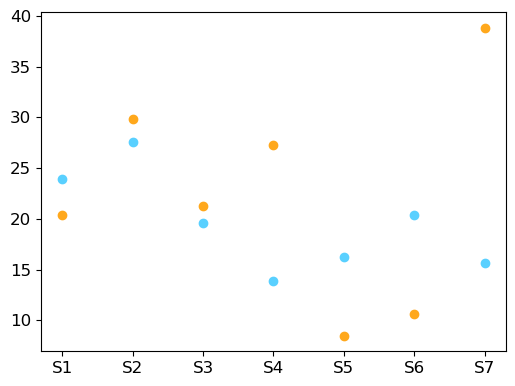

In [46]:
fig, ax = plt.subplots(figsize=(6,4.4))

plt.rcParams.update({'font.size': 12})

#plt.plot(M34, color=colors['blue'], label="M34")
#plt.plot(M35, color=colors['orange'], label="M35")
# plt.plot(M37, color=colors['green'], label="M37")
#plt.plot(np.linspace(0, 6, 14), y_pred, color=colors['black'], linestyle='-', linewidth=2, zorder=1)
# plt.plot(mean_sessions, color=colors['black'], linewidth=2, label='Moyenne', alpha=0.8)

# Increase zorder for scatter plots
plt.scatter([0, 1, 2, 3, 4, 5, 6], ten_amp[::2], color=colors['blue'], zorder=3)
plt.scatter([0, 1, 2, 3, 4, 5, 6], ten_amp[1::2], color=colors['orange'], zorder=3)
# plt.scatter([0, 1, 2, 3, 4, 5, 6], M37[:7], color=colors['green'], zorder=3)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7'])
#plt.legend()

# Save the figure
#plt.savefig('/Users/vincentchouinard/Documents/Maitrise/Inkscape_figures/Age_CVR/M3435_S1S7_data_reg.svg')